In [1]:
#import helper
#import network

#from helper import *
#from network import *

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import pandas as pd
from tqdm.notebook import tqdm
import seaborn as sns  # For boxplot
import plotly.graph_objects as go

from sklearn.neighbors import NearestNeighbors
from colorsys import rgb_to_hsv, hsv_to_rgb
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

torch.manual_seed(17)
np.random.seed(17)

## Functions + Model

In [2]:
# Functions for generating RGB samples, converting to HSV, and visualizing

def generate_rgb_samples(n_samples):
    """Generate random RGB samples between 0 and 1"""
    rgb_samples = np.random.uniform(0, 1, (n_samples, 3))
    return rgb_samples

def rgb_to_hsv_batch(rgb_samples):
    """Convert batch of RGB samples to HSV"""
    hsv_samples = np.array([rgb_to_hsv(*rgb) for rgb in rgb_samples])
    return hsv_samples

def visualize_samples(rgb_samples):
    """Visualize RGB samples in 3D space"""
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot points
    ax.scatter(
        rgb_samples[:, 0],
        rgb_samples[:, 1],
        rgb_samples[:, 2],
        c=rgb_samples,
        marker='o',
        s = 5
    )
    
    ax.set_xlabel('R')
    ax.set_ylabel('G')
    ax.set_zlabel('B')
    ax.set_title('RGB Color Space Samples')
    plt.show()
    
def visualize_hsv_samples(hsv_samples):
    """
    Visualize HSV samples in 3D space, with points colored by their RGB equivalents
    
    Args:
        hsv_samples: numpy array of HSV values, shape (n_samples, 3)
    """
    # Convert HSV to RGB for coloring
    rgb_colors = np.array([hsv_to_rgb(*hsv) for hsv in hsv_samples])
    
    # Create 3D plot
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot points
    scatter = ax.scatter(
        hsv_samples[:, 0],  # Hue
        hsv_samples[:, 1],  # Saturation
        hsv_samples[:, 2],  # Value
        c=rgb_colors,       # Color points by their RGB values
        marker='o',
        s=5
    )

def visualize_model_structure(model):
    """
    Visualize the structure of the neural network model with detailed layer information
    """
    def count_parameters(layer):
        return sum(p.numel() for p in layer.parameters() if p.requires_grad)
    
    print("\nNeural Network Structure")
    print("=" * 85)
    print(f"{'#':<3} {'Layer Type':<20} {'Input Shape':<15} {'Output Shape':<15} {'Parameters':<12} {'Activation':<10}")
    print("-" * 85)
    
    # Input layer
    print(f"{'0':<3} {'Input':<20} {'(-, 3)':<15} {'(-, 3)':<15} {'0':<12} {'None':<10}")
    
    # Track the current shape
    current_shape = 3
    
    # Iterate through model layers
    for i, layer in enumerate(model.model):
        if isinstance(layer, nn.Linear):
            in_features = layer.in_features
            out_features = layer.out_features
            params = count_parameters(layer)
            print(f"{i+1:<3} {'Linear':<20} {'(-, '+str(in_features)+')':<15} "
                  f"{'(-, '+str(out_features)+')':<15} {str(params):<12} {'None':<10}")
            current_shape = out_features
        elif isinstance(layer, nn.ReLU):
            print(f"{i+1:<3} {'ReLU':<20} {'(-, '+str(current_shape)+')':<15} "
                  f"{'(-, '+str(current_shape)+')':<15} {'0':<12} {'ReLU':<10}")
    
    print("=" * 85)
    total_params = count_parameters(model)
    print(f"Total trainable parameters: {total_params:,}")
    print(f"Final output shape: (batch_size, 3) [HSV values]")

def train_model(model, train_loader, num_epochs, learning_rate=0.01):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for batch_rgb, batch_hsv in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_rgb)
            loss = criterion(outputs, batch_hsv)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
        if (epoch + 1) % 10 == 0:
            avg_loss = running_loss / len(train_loader)
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

def filter_rgb_data(rgb_data, center_color, keep_percentage):

    # Convert inputs to numpy arrays if they aren't already
    rgb_data = np.array(rgb_data)
    center_color = np.array(center_color)
    
    # Calculate Euclidean distances from center color to all samples
    distances = np.sqrt(np.sum((rgb_data - center_color) ** 2, axis=1))
    
    # Sort distances and find threshold for desired percentage
    sorted_distances = np.sort(distances)
    n_keep = int(len(rgb_data) * (keep_percentage / 100))
    threshold = sorted_distances[n_keep - 1]
    
    # Create mask for samples to keep
    mask = distances > threshold
    
    # Apply mask to get filtered data
    filtered_rgb = rgb_data[mask]
    
    # Print statistics
    kept_count = len(filtered_rgb)
    total_count = len(rgb_data)
    actual_percentage = (kept_count / total_count) * 100
    
    print(f"Kept {kept_count} samples ({actual_percentage:.1f}%) "
          f"outside radius {threshold:.3f} of {center_color}")
    
    return filtered_rgb, mask, threshold

def visualize_color_comparison(color1, color2, color1_space='rgb', color2_space='rgb', 
                              color1_name="Color 1", color2_name="Color 2",
                              title="Color Comparison", show_title=True, show_distance=True):

    import matplotlib.pyplot as plt
    import numpy as np
    from colorsys import hsv_to_rgb
    
    # Convert colors to numpy arrays
    color1 = np.array(color1)
    color2 = np.array(color2)
    
    # Convert to RGB if colors are in HSV space
    rgb1 = color1 if color1_space.lower() == 'rgb' else np.array(hsv_to_rgb(*color1))
    rgb2 = color2 if color2_space.lower() == 'rgb' else np.array(hsv_to_rgb(*color2))
    
    # Create figure with two color patches
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
    
    # Display colors
    ax1.add_patch(plt.Rectangle((0, 0), 1, 1, color=rgb1))
    ax2.add_patch(plt.Rectangle((0, 0), 1, 1, color=rgb2))
    
    # Remove axes
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax2.set_xticks([])
    ax2.set_yticks([])
    
    # Set labels based on color space
    space1_label = f"({color1_space.upper()})" if color1_space.lower() != 'rgb' else ''
    space2_label = f"({color2_space.upper()})" if color2_space.lower() != 'rgb' else ''
    
    # Format color values with more precision for display
    rgb1_str = f"RGB: ({rgb1[0]:.3f}, {rgb1[1]:.3f}, {rgb1[2]:.3f})"
    rgb2_str = f"RGB: ({rgb2[0]:.3f}, {rgb2[1]:.3f}, {rgb2[2]:.3f})"
    
    # Add color space specific values if not RGB
    if color1_space.lower() != 'rgb':
        hsv1_str = f"HSV: ({color1[0]:.3f}, {color1[1]:.3f}, {color1[2]:.3f})"
        ax1.set_title(f"{color1_name} {space1_label}\n{rgb1_str}\n{hsv1_str}")
    else:
        ax1.set_title(f"{color1_name}\n{rgb1_str}")
        
    if color2_space.lower() != 'rgb':
        hsv2_str = f"HSV: ({color2[0]:.3f}, {color2[1]:.3f}, {color2[2]:.3f})"
        ax2.set_title(f"{color2_name} {space2_label}\n{rgb2_str}\n{hsv2_str}")
    else:
        ax2.set_title(f"{color2_name}\n{rgb2_str}")
    
    # Calculate L2 distance between RGB values
    distance = color_l2_distance(rgb1, rgb2)
    
    # Set main title based on toggle options
    if show_title:
        if show_distance:
            plt.suptitle(f"{title}\nL2 Distance: {distance:.6f}", fontsize=14)
        else:
            plt.suptitle(f"{title}", fontsize=14)
    
    # Adjust layout
    if show_title:
        plt.tight_layout(rect=[0, 0, 1, 0.9])  # Make room for suptitle
    else:
        plt.tight_layout()
        
    plt.show()
    
    return distance

In [3]:
def find_color_knn(target_color, dataset, k=5):

    # Handle different input types
    if isinstance(dataset, pd.DataFrame):
        # Determine which columns contain color information
        color_columns = dataset.columns[:3].tolist()  # Assuming first 3 columns are color components
        X = dataset[color_columns].values
    else:
        X = np.array(dataset)
    
    # Reshape target_color if needed
    target_color = np.array(target_color).reshape(1, -1)
    
    # Use sklearn's KNN with Euclidean distance
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto', metric='euclidean').fit(X)
    distances, indices = nbrs.kneighbors(target_color)
    
    # Flatten arrays for easier use
    indices = indices.flatten()
    distances = distances.flatten()
    
    # Return the k nearest neighbors, distances, and indices
    if isinstance(dataset, pd.DataFrame):
        return dataset.iloc[indices], distances, indices
    else:
        return X[indices], distances, indices

def blend_with_inverse_distance_weighting(colors, distances, p=2):

    import numpy as np
    
    # Convert inputs to numpy arrays if they aren't already
    colors = np.array(colors)
    distances = np.array(distances)
    
    # Avoid division by zero by adding small epsilon to distances
    epsilon = 1e-10
    distances = np.maximum(distances, epsilon)
    
    # Calculate weights using inverse distance weighting formula
    weights = 1.0 / (distances ** p)
    
    # Normalize weights to sum to 1
    weights = weights / np.sum(weights)
    
    # Apply weights to each color and sum
    # Reshape weights to allow broadcasting
    weights_reshaped = weights.reshape(-1, 1)
    weighted_colors = colors * weights_reshaped
    blended_color = np.sum(weighted_colors, axis=0)
    
    return blended_color

def color_l2_distance(color1, color2):

    # Ensure inputs are numpy arrays
    color1 = np.array(color1)
    color2 = np.array(color2)
    
    # Calculate Euclidean distance
    squared_diff = (color1 - color2) ** 2
    sum_squared_diff = np.sum(squared_diff)
    distance = np.sqrt(sum_squared_diff)
    
    return distance

def adaptive_knn_blending(rgb_data, center_color, min_k=1, max_k=30, filter_percent=0):

    # Convert rgb_data to DataFrame if it isn't already
    if not isinstance(rgb_data, pd.DataFrame):
        rgb_data = pd.DataFrame(rgb_data, columns=['R', 'G', 'B'])
    
    # Convert center_color to numpy array
    center_color = np.array(center_color)
    
    # Apply filtering if requested
    if filter_percent > 0:
        # Calculate max distance in the color space
        if np.max(rgb_data.values) <= 1.0:  # Normalized data [0,1]
            max_distance = np.sqrt(3)
        else:  # Standard RGB [0,255]
            max_distance = np.sqrt(3 * 255**2)
        
        # Calculate filter threshold
        threshold = (filter_percent / 100) * max_distance
        
        # Filter out colors that are too close
        filtered_data = []
        for idx, row in rgb_data.iterrows():
            color = row.iloc[:3].values
            dist = color_l2_distance(center_color, color)
            if dist > threshold:
                filtered_data.append(row)
        
        if filtered_data:  # Only use filtered data if some points remain
            filtered_rgb = pd.DataFrame(filtered_data)
        else:
            filtered_rgb = rgb_data
    else:
        # No filtering
        filtered_rgb = rgb_data
    
    # Dictionary to store distances for each k
    all_distances = {}
    
    # Find best k
    best_k = min_k
    best_distance = float('inf')
    best_blended_color = None
    
    # Test each k value
    for k in range(min_k, min(max_k + 1, len(filtered_rgb))):
        # Find k nearest neighbors
        neighbors, dists, _ = find_color_knn(center_color, filtered_rgb, k=k)
        
        # Get color values
        if isinstance(neighbors, pd.DataFrame):
            neighbor_colors = neighbors.iloc[:, :3].values
        else:
            neighbor_colors = neighbors
        
        # Blend colors
        blended_color = blend_with_inverse_distance_weighting(neighbor_colors, dists)
        
        # Calculate distance
        distance = color_l2_distance(center_color, blended_color)
        
        # Store result
        all_distances[k] = distance
        
        # Check if this is better than current best
        if distance < best_distance:
            best_k = k
            best_distance = distance
            best_blended_color = blended_color
    
    print(f"Optimal number of neighbors: {best_k}")
    print(f"Best distance: {best_distance:.6f}")
    
    return best_k, best_distance, best_blended_color, all_distances

# Example visualization of the results:
def plot_adaptive_knn_results(all_distances):

    k_values = list(all_distances.keys())
    distances = list(all_distances.values())
    
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, distances, 'o-', color='blue', linewidth=2, markersize=6)
    
    # Find minimum point
    best_k = k_values[np.argmin(distances)]
    min_dist = min(distances)
    plt.plot(best_k, min_dist, 'ro', markersize=10, label=f'Best k={best_k}')
    
    # Customize plot
    plt.xlabel('Number of Neighbors (k)')
    plt.ylabel('L2 Distance')
    plt.title('Effect of Neighbor Count on Blending Accuracy')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    
    plt.show()

def test_multiple_knn_approaches(rgb_data, num_tests=20, filter_percent=0, 
                                k_values=[1, 5, 10, 15], use_adaptive=True,
                                adaptive_min_k=1, adaptive_max_k=30):

    # Convert rgb_data to DataFrame if it isn't already
    if not isinstance(rgb_data, pd.DataFrame):
        rgb_data = pd.DataFrame(rgb_data, columns=['R', 'G', 'B'])
    
    # Prepare results dictionary
    results = {}
    for k in k_values:
        results[f'k={k}'] = []
    
    if use_adaptive:
        results['adaptive'] = []
        results['adaptive_k'] = []  # To track what k was chosen by adaptive method
    
    #print(f"Testing {num_tests} random center colors...")
    
    # For each test, select a random center color
    for i in range(num_tests):
        if i % 5 == 0 or i == num_tests - 1:
            print(f"Test {i+1}/{num_tests}")
            
        # Randomly select a center color
        center_index = np.random.randint(0, len(rgb_data))
        center_color = rgb_data.iloc[center_index, :3].values
        
        # Apply filtering if requested
        if filter_percent > 0:
            # Calculate max distance in the color space
            if np.max(rgb_data.values) <= 1.0:  # Normalized data [0,1]
                max_distance = np.sqrt(3)
            else:  # Standard RGB [0,255]
                max_distance = np.sqrt(3 * 255**2)
            
            # Calculate filter threshold
            threshold = (filter_percent / 100) * max_distance
            
            # Filter out colors that are too close
            filtered_data = []
            for idx, row in rgb_data.iterrows():
                color = row.iloc[:3].values
                dist = color_l2_distance(center_color, color)
                if dist > threshold:
                    filtered_data.append(row)
            
            if filtered_data:  # Only use filtered data if some points remain
                filtered_rgb = pd.DataFrame(filtered_data)
            else:
                filtered_rgb = rgb_data
        else:
            # No filtering
            filtered_rgb = rgb_data
        
        # Test each fixed k value
        for k in k_values:
            # Make sure k doesn't exceed dataset size
            actual_k = min(k, len(filtered_rgb))
            
            # Find k nearest neighbors
            neighbors, dists, _ = find_color_knn(center_color, filtered_rgb, k=actual_k)
            
            # Get color values
            if isinstance(neighbors, pd.DataFrame):
                neighbor_colors = neighbors.iloc[:, :3].values
            else:
                neighbor_colors = neighbors
            
            # Blend colors
            blended_color = blend_with_inverse_distance_weighting(neighbor_colors, dists)
            
            # Calculate distance
            distance = color_l2_distance(center_color, blended_color)
            
            # Store result
            results[f'k={k}'].append(distance)
        
        # Test adaptive approach if requested
        if use_adaptive:
            best_k, best_distance, _, _ = adaptive_knn_blending(
                filtered_rgb, center_color, 
                min_k=adaptive_min_k, 
                max_k=min(adaptive_max_k, len(filtered_rgb)),
                filter_percent=0  # Already filtered above if needed
            )
            results['adaptive'].append(best_distance)
            results['adaptive_k'].append(best_k)
    
    print("Testing complete!")
    
    return results

def plot_knn_approach_comparison(results):

    # Prepare data for boxplot
    approaches = []
    all_distances = []
    
    for approach, distances in results.items():
        if approach != 'adaptive_k':  # Skip the adaptive_k storage
            approaches.extend([approach] * len(distances))
            all_distances.extend(distances)
    
    # Create DataFrame for plotting
    df = pd.DataFrame({
        'Approach': approaches,
        'Distance': all_distances
    })
    
    # Create boxplot
    plt.figure(figsize=(12, 6))
    
    # Set custom order for boxplot categories
    ordered_categories = [f'k={k}' for k in sorted([int(k.split('=')[1]) for k in results.keys() if k.startswith('k=')])]
    if 'adaptive' in results:
        ordered_categories.append('adaptive')
    
    # Create boxplot with custom order
    sns.boxplot(x='Approach', y='Distance', data=df, order=ordered_categories)
    
    # Add individual data points
    sns.stripplot(x='Approach', y='Distance', data=df, color='black', size=3, alpha=0.3, order=ordered_categories)
    
    # Add labels and title
    plt.ylabel('L2 Distance')
    plt.title('Comparison of KNN Approaches for Color Blending')
    
    # Add horizontal grid lines
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # Add text for adaptive approach if available
    if 'adaptive' in results and 'adaptive_k' in results:
        avg_k = np.mean(results['adaptive_k'])
        plt.text(len(ordered_categories) - 0.25, plt.gca().get_ylim()[0] + 0.01, 
                 f"Avg k: {avg_k:.1f}", ha='center', fontsize=9)
        
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print("\nApproach Statistics:")
    print("-" * 50)
    print(f"{'Approach':<12} {'Mean':<8} {'Min':<8} {'Max':<8} {'Std Dev':<8}")
    print("-" * 50)
    
    for approach in ordered_categories:
        distances = results[approach]
        print(f"{approach:<12} {np.mean(distances):.6f} {np.min(distances):.6f} {np.max(distances):.6f} {np.std(distances):.6f}")

In [4]:
def test_single_center_color(rgb_data, center_color, k_neighbors=15, 
                           min_percent=0, max_percent=50, step_size=5):

    # Convert rgb_data to DataFrame if it isn't already
    if not isinstance(rgb_data, pd.DataFrame):
        rgb_data = pd.DataFrame(rgb_data, columns=['R', 'G', 'B'])
    
    # Convert center_color to numpy array if it isn't already
    center_color = np.array(center_color)
    
    # Prepare filter thresholds from min_percent to max_percent
    filter_percents = np.arange(min_percent, max_percent + step_size, step_size)
    
    # Array to store distances
    distances = np.zeros(len(filter_percents))
    
    # For each filter percentage
    for i, filter_percent in enumerate(filter_percents):
        # Filter the dataset (exclude points within filter_percent% distance)
        if filter_percent > 0:
            # Calculate max distance in the color space
            if np.max(rgb_data.values) <= 1.0:  # Normalized data [0,1]
                max_distance = np.sqrt(3)
            else:  # Standard RGB [0,255]
                max_distance = np.sqrt(3 * 255**2)
            
            # Calculate filter threshold
            threshold = (filter_percent / 100) * max_distance
            
            # Filter out colors that are too close
            filtered_data = []
            for idx, row in rgb_data.iterrows():
                color = row.iloc[:3].values
                dist = color_l2_distance(center_color, color)
                if dist > threshold:
                    filtered_data.append(row)
            
            if not filtered_data:  # If filtering removed all points
                filtered_rgb = rgb_data  # Use full dataset if no points remain
            else:
                filtered_rgb = pd.DataFrame(filtered_data)
        else:
            # No filtering at 0%
            filtered_rgb = rgb_data
        
        # Find KNN and blend
        k = min(k_neighbors, len(filtered_rgb))
        if k == 0:
            # If no neighbors remain after filtering
            distances[i] = np.nan
            continue
            
        neighbors, dists, _ = find_color_knn(center_color, filtered_rgb, k=k)
        
        # Get color values if neighbors is a DataFrame
        if isinstance(neighbors, pd.DataFrame):
            neighbor_colors = neighbors.iloc[:, :3].values
        else:
            neighbor_colors = neighbors
            
        blended_color = blend_with_inverse_distance_weighting(neighbor_colors, dists)
        
        # Calculate distance between center and blended color
        distance = color_l2_distance(center_color, blended_color)
        
        # Store result
        distances[i] = distance
    
    return filter_percents, distances

def test_multiple_center_colors(rgb_data, num_tests=10, k_neighbors=15,
                             min_percent=0, max_percent=50, step_size=5):
    
    # Convert rgb_data to DataFrame if it isn't already
    if not isinstance(rgb_data, pd.DataFrame):
        rgb_data = pd.DataFrame(rgb_data, columns=['R', 'G', 'B'])
    
    # Calculate filter percentages once
    filter_percents = np.arange(min_percent, max_percent + step_size, step_size)
    
    # Initialize array for all results
    all_distances = np.zeros((num_tests, len(filter_percents)))
    
    print(f"Testing {num_tests} random center colors...")
    
    # For each test, select a random center color and run the test
    for i in range(num_tests):
        if i % 5 == 0 or i == num_tests - 1:
            print(f"Test {i+1}/{num_tests}")
            
        # Randomly select a center color
        center_index = np.random.randint(0, len(rgb_data))
        center_color = rgb_data.iloc[center_index, :3].values
        
        # Run test for this center color
        _, distances = test_single_center_color(
            rgb_data, center_color, k_neighbors, 
            min_percent, max_percent, step_size
        )
        
        # Store results
        all_distances[i] = distances
    
    # Calculate averages and standard deviations
    avg_distances = np.nanmean(all_distances, axis=0)
    std_distances = np.nanstd(all_distances, axis=0)
    
    print("Testing complete!")
    
    return filter_percents, all_distances, avg_distances, std_distances

def simple_plot_filter_results(filter_percents, distances, title="Filter Effect on Distance"):
    """
    Create a simple line graph showing filter percentages vs. distances.
    
    Parameters:
    -----------
    filter_percents : array-like
        Array of filter percentages tested
    distances : array-like
        Array of corresponding distances
    title : str, default="Filter Effect on Distance"
        Title for the plot
    """
    plt.figure(figsize=(8, 5))
    
    # Create a simple line plot with markers
    plt.plot(filter_percents, distances, 'o-', color='blue', 
             linewidth=2, markersize=6)
    
    # Customize the plot
    plt.xlabel('Filter Percentage (%)')
    plt.ylabel('Distance')
    plt.title(title)
    plt.grid(True, alpha=0.3)
    
    # Add a horizontal line at y=0 for reference
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    
    # Set y-axis to start from 0 if all distances are positive
    if np.min(distances) >= 0:
        plt.ylim(bottom=0)
    
    plt.tight_layout()
    plt.show()


def plot_filter_test_results(filter_percents, avg_distances, std_distances):

    plt.figure(figsize=(10, 6))
    
    # Plot line with markers
    plt.plot(filter_percents, avg_distances, 'o-', color='blue', 
             linewidth=2, markersize=6, label='Average Distance')
    
    # Add shaded error region
    plt.fill_between(filter_percents, 
                     avg_distances - std_distances, 
                     avg_distances + std_distances,
                     alpha=0.2, color='blue',
                     label='±1 Std Dev')
    
    plt.xlabel('Filter Threshold (%)')
    plt.ylabel('L2 Distance')
    plt.title('Effect of Filtering on Color Blending Accuracy')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    
    plt.show()

In [5]:
# Classes for custom dataset and model

class RGBHSVDataset(Dataset):
    """Custom Dataset for RGB-HSV conversion"""
    def __init__(self, rgb_data, hsv_data):
        self.rgb_data = torch.FloatTensor(rgb_data)
        self.hsv_data = torch.FloatTensor(hsv_data)
        
    def __len__(self):
        return len(self.rgb_data)
    
    def __getitem__(self, idx):
        return self.rgb_data[idx], self.hsv_data[idx]

class RGBtoHSV(nn.Module):
    def __init__(self):
        super(RGBtoHSV, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(3, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 3),
            # No activation on final layer as HSV has different ranges
        )
    
    def forward(self, x):
        return self.model(x)

In [6]:
# Specific for collecting Data

def collect_activations(model, train_loader):
    """Collect all activations from the network during one forward pass"""
    
    # Lists to store inputs, activations, and outputs
    all_inputs = []
    all_activations = []
    all_outputs = []
    
    # Dictionary to store intermediate activations for each forward pass
    activation_dict = {}
    
    # Hook function to capture activations
    def hook_fn(module, input, output):
        activation_dict[len(activation_dict)] = output.detach().cpu().numpy()
    
    # Register hooks for all layers except the final one
    hooks = []
    for layer in list(model.model)[:-1]:  # Exclude the final layer
        hooks.append(layer.register_forward_hook(hook_fn))
    
    # Set model to eval mode
    model.eval()
    
    # Forward pass through all samples
    with torch.no_grad():
        for batch_rgb, _ in train_loader:
            # Store inputs
            all_inputs.append(batch_rgb.numpy())
            
            # Forward pass
            outputs = model(batch_rgb)
            
            # Store outputs
            all_outputs.append(outputs.numpy())
            
            # Store activations for this batch
            batch_activations = []
            for i in range(len(activation_dict)):
                batch_activations.append(activation_dict[i])
            all_activations.append(np.concatenate([act.reshape(act.shape[0], -1) for act in batch_activations], axis=1))
            
            # Clear activation dictionary for next batch
            activation_dict.clear()
    
    # Remove hooks
    for hook in hooks:
        hook.remove()
    
    # Concatenate all batches
    inputs = np.concatenate(all_inputs, axis=0)
    activations = np.concatenate(all_activations, axis=0)
    outputs = np.concatenate(all_outputs, axis=0)
    
    return inputs, activations, outputs

def collect_single_color_activations(model, rgb_color):
    """
    Collect activations from the network for a single RGB color input
    
    Args:
        model: The trained neural network model
        rgb_color: RGB color values as numpy array or list [r, g, b]
        
    Returns:
        tuple: (input_rgb, activations, output_hsv)
            - input_rgb: The input RGB values
            - activations: Hidden layer activation patterns
            - output_hsv: The output HSV values
    """
    # Convert input to tensor and add batch dimension
    rgb_tensor = torch.FloatTensor(rgb_color).unsqueeze(0)
    
    # Dictionary to store activations
    activation_dict = {}
    
    # Hook function to capture activations
    def hook_fn(module, input, output):
        activation_dict[len(activation_dict)] = output.detach().cpu().numpy()
    
    # Register hooks for all layers except the final one
    hooks = []
    for layer in list(model.model)[:-1]:
        hooks.append(layer.register_forward_hook(hook_fn))
    
    # Get model prediction and activations
    model.eval()
    with torch.no_grad():
        output = model(rgb_tensor)
    
    # Concatenate activations
    activations = np.concatenate([act.reshape(act.shape[0], -1) 
                                for act in list(activation_dict.values())], axis=1)
    
    # Remove hooks
    for hook in hooks:
        hook.remove()
    
    return (rgb_tensor.numpy(), activations, output.numpy())

def blend_with_custom_weights(dataset, indices=None, weights=None):
    """
    Blend colors from a dataset using custom indices and weights.
    
    Parameters:
    -----------
    dataset : array-like or DataFrame
        The dataset containing color values to blend
    indices : array-like, optional
        Indices of colors in the dataset to use for blending.
        If None, all colors in the dataset will be used.
    weights : array-like, optional
        Custom weights for each color. Must match the length of indices if provided.
        If None, equal weights will be assigned to all colors.
        
    Returns:
    --------
    blended_color : ndarray
        The blended color
    """
    import numpy as np
    
    # Handle DataFrame input
    if isinstance(dataset, pd.DataFrame):
        # Assuming first three columns are colors
        colors = dataset.iloc[:, :3].values
    else:
        colors = np.array(dataset)
    
    # Use specified indices if provided
    if indices is not None:
        colors = colors[indices]
    
    # Use provided weights or create equal weights
    if weights is None:
        weights = np.ones(len(colors)) / len(colors)
    else:
        # Ensure weights are normalized
        weights = np.array(weights)
        weights = weights / np.sum(weights)
    
    # Reshape weights for broadcasting
    weights_reshaped = weights.reshape(-1, 1)
    
    # Apply weights and sum
    weighted_colors = colors * weights_reshaped
    blended_color = np.sum(weighted_colors, axis=0)
    
    return blended_color

def calculate_inverse_distance_weights(center_color, dataset, indices=None, p=2):
    """
    Calculate inverse distance weights for blending.
    
    Parameters:
    -----------
    center_color : array-like
        The reference color for calculating distances
    dataset : array-like or DataFrame
        The dataset containing color values
    indices : array-like, optional
        Indices of colors in the dataset to use.
        If None, all colors in the dataset will be used.
    p : float, default=2
        Power parameter for inverse distance weighting
        
    Returns:
    --------
    weights : ndarray
        Normalized weights for blending
    distances : ndarray
        Distances from center color to each selected color
    """
    import numpy as np
    
    # Handle DataFrame input and extract colors
    if isinstance(dataset, pd.DataFrame):
        if indices is not None:
            colors = dataset.iloc[indices, :3].values
        else:
            colors = dataset.iloc[:, :3].values
    else:
        colors = np.array(dataset)
        if indices is not None:
            colors = colors[indices]
    
    # Calculate distances from center color to all colors
    center_color = np.array(center_color)
    squared_diff = (colors - center_color) ** 2
    distances = np.sqrt(np.sum(squared_diff, axis=1))
    
    # Avoid division by zero
    epsilon = 1e-10
    distances = np.maximum(distances, epsilon)
    
    # Calculate weights using inverse distance weighting formula
    weights = 1.0 / (distances ** p)
    
    # Normalize weights to sum to 1
    weights = weights / np.sum(weights)
    
    return weights, distances

In [7]:
def plot_activations_line(activations, inputs, num_examples=5, figsize=(12, 8), alpha=0.1):
    """
    Create a simple line plot of neural network activations for random examples.
    
    Parameters:
    -----------
    activations : array-like
        Array of activation values from the hidden layers with shape (samples, neurons)
    inputs : array-like
        Array of input RGB colors with shape (samples, 3)
    num_examples : int, default=5
        Number of random examples to display
    figsize : tuple, default=(12, 8)
        Figure size as (width, height) in inches
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Select random examples
    sample_count = activations.shape[0]
    random_indices = np.random.choice(sample_count, size=min(num_examples, sample_count), replace=False)
    
    # Create figure
    plt.figure(figsize=figsize)
    
    # Plot each random example
    for i, idx in enumerate(random_indices):
        # Get the activation values for this example
        example_activations = activations[idx]
        
        # Get the RGB color for this example
        rgb_color = inputs[idx]
        
        # Plot activation values as a line
        x = np.arange(len(example_activations))
        plt.plot(x, example_activations, color=rgb_color, alpha=alpha,
                 label=f"RGB: ({rgb_color[0]:.2f}, {rgb_color[1]:.2f}, {rgb_color[2]:.2f})")
    
    # Add labels and title
    plt.xlabel('Neuron Index')
    plt.ylabel('Activation Value')
    plt.title(f'Neural Network Activations for {num_examples} Random Colors')
    
    # Add legend and grid
    #plt.legend(loc='upper right')
    plt.grid(True, alpha=0.7)
    
    # Show plot
    plt.tight_layout()
    plt.show()

In [8]:
def evaluate_activation_dimensions_fixed_neighbors(model, new_color, all_activations, all_inputs, all_outputs,
                                                  min_dims=3, max_dims=None, step_size=10, k=15):
    """
    Evaluate how the number of activation dimensions affects blending accuracy,
    using the same set of neighbors for each evaluation.
    Evaluates both input (RGB) and output (HSV) space accuracy.
    
    Parameters:
    -----------
    model : torch model
        The trained neural network model
    new_color : array-like
        The RGB color to evaluate
    all_activations : array-like
        The activations from the training set
    all_inputs : array-like
        The corresponding RGB inputs from the training set
    all_outputs : array-like
        The corresponding HSV outputs from the training set
    min_dims : int, default=3
        Minimum number of activation dimensions to use for blending
    max_dims : int, default=None
        Maximum number of activation dimensions to use for blending
    step_size : int, default=10
        Step size for increasing dimensions
    k : int, default=15
        Number of neighbors to find for blending
        
    Returns:
    --------
    dimensions : list
        List of dimension counts evaluated
    rgb_distances : list
        L2 distances between original RGB and blended RGB for each dimension count
    hsv_distances : list
        L2 distances between predicted HSV and blended HSV for each dimension count
    """
    # Collect activations and output for the new color
    _, new_activations, new_hsv_output = collect_single_color_activations(model, new_color)
    
    # Flatten activations
    new_activations_flat = new_activations.flatten()
    
    # Set default max_dims if not provided
    if max_dims is None:
        max_dims = all_activations.shape[1]
    
    # Find k nearest neighbors in the FULL activation space first
    _, neighbor_distances, indices = find_color_knn(
        new_activations, all_activations, k=k)
    
    # Get the corresponding RGB colors and HSV outputs of these neighbors
    neighbor_rgb_colors = all_inputs[indices]
    neighbor_hsv_values = all_outputs[indices]
    
    # Create arrays to store results
    dimensions = []
    rgb_distances = []
    hsv_distances = []
    
    # Loop through increasing dimensions for blending weights calculation
    for n_dims in range(min_dims, max_dims + 1, step_size):
        # Use only the first n_dims of activations for distance calculation
        limited_new_activations = new_activations_flat[:n_dims].reshape(1, -1)
        limited_neighbor_activations = all_activations[indices, :n_dims]
        
        # Calculate distances in the limited activation space
        limited_distances = np.sqrt(np.sum((limited_new_activations - limited_neighbor_activations)**2, axis=1))
        
        # 1. Blend RGB colors using inverse distance weighting
        blended_rgb = blend_with_inverse_distance_weighting(neighbor_rgb_colors, limited_distances)
        
        # Calculate L2 distance between original and blended RGB colors
        rgb_distance = color_l2_distance(new_color, blended_rgb)
        
        # 2. Blend HSV values using inverse distance weighting
        blended_hsv = blend_with_inverse_distance_weighting(neighbor_hsv_values, limited_distances)
        
        # Calculate L2 distance between predicted and blended HSV values
        hsv_distance = color_l2_distance(new_hsv_output.flatten(), blended_hsv)
        
        # Store results
        dimensions.append(n_dims)
        rgb_distances.append(rgb_distance)
        hsv_distances.append(hsv_distance)
        
    return dimensions, rgb_distances, hsv_distances

def plot_dimension_results(dimensions, distances, title="Effect of Activation Dimensions on Color Blending Accuracy"):
    """
    Plot the results of the activation dimension evaluation.
    
    Parameters:
    -----------
    dimensions : list
        List of dimension counts evaluated
    distances : list
        Corresponding L2 distances
    title : str, default="Effect of Activation Dimensions on Color Blending Accuracy"
        Plot title
    """
    plt.figure(figsize=(12, 6))
    plt.plot(dimensions, distances, 'o-', color='blue', linewidth=2, markersize=6)
    
    # Find minimum point
    min_idx = np.argmin(distances)
    min_dims = dimensions[min_idx]
    min_dist = distances[min_idx]
    plt.plot(min_dims, min_dist, 'ro', markersize=10, 
             label=f'Best dims={min_dims} (distance={min_dist:.6f})')
    
    # Customize plot
    plt.xlabel('Number of Activation Dimensions Used')
    plt.ylabel('L2 Distance')
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Annotate some key points
    # plt.annotate(f"{dimensions[0]} dims", 
    #              xy=(dimensions[0], distances[0]),
    #              xytext=(dimensions[0] + 10, distances[0] + 0.01),
    #              arrowprops=dict(arrowstyle='->'))
    
    # if dimensions[-1] > 300:
    #     plt.annotate(f"{dimensions[-1]} dims", 
    #                  xy=(dimensions[-1], distances[-1]),
    #                  xytext=(dimensions[-1] - 100, distances[-1] + 0.01),
    #                  arrowprops=dict(arrowstyle='->'))
    
    plt.tight_layout()
    plt.show()

def plot_dual_dimension_results(dimensions, rgb_distances, hsv_distances, 
                               title="Effect of Activation Dimensions on Color Blending Accuracy"):
    """
    Plot the results of the activation dimension evaluation for both RGB and HSV spaces.
    
    Parameters:
    -----------
    dimensions : list
        List of dimension counts evaluated
    rgb_distances : list
        L2 distances in RGB space for each dimension count
    hsv_distances : list
        L2 distances in HSV space for each dimension count
    title : str
        Plot title
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot RGB distances
    ax1.plot(dimensions, rgb_distances, 'o-', color='blue', linewidth=2, markersize=6)
    
    # Find minimum RGB point
    rgb_min_idx = np.argmin(rgb_distances)
    rgb_min_dims = dimensions[rgb_min_idx]
    rgb_min_dist = rgb_distances[rgb_min_idx]
    ax1.plot(rgb_min_dims, rgb_min_dist, 'ro', markersize=10, 
            label=f'Best dims={rgb_min_dims}\n(distance={rgb_min_dist:.6f})')
    
    # Customize RGB plot
    ax1.set_xlabel('Number of Activation Dimensions Used')
    ax1.set_ylabel('RGB L2 Distance')
    ax1.set_title('RGB Space Accuracy')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Plot HSV distances
    ax2.plot(dimensions, hsv_distances, 'o-', color='green', linewidth=2, markersize=6)
    
    # Find minimum HSV point
    hsv_min_idx = np.argmin(hsv_distances)
    hsv_min_dims = dimensions[hsv_min_idx]
    hsv_min_dist = hsv_distances[hsv_min_idx]
    ax2.plot(hsv_min_dims, hsv_min_dist, 'ro', markersize=10, 
            label=f'Best dims={hsv_min_dims}\n(distance={hsv_min_dist:.6f})')
    
    # Customize HSV plot
    ax2.set_xlabel('Number of Activation Dimensions Used')
    ax2.set_ylabel('HSV L2 Distance')
    ax2.set_title('HSV Space Accuracy')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # Set main title
    fig.suptitle(title, fontsize=16)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Make room for suptitle
    plt.show()
    
    return {
        'rgb_best_dims': rgb_min_dims,
        'rgb_min_distance': rgb_min_dist,
        'hsv_best_dims': hsv_min_dims,
        'hsv_min_distance': hsv_min_dist
    }

def test_multiple_colors_dimensionality(model, all_activations, all_inputs, all_outputs,
                                       num_tests=10, min_dims=3, max_dims=None, 
                                       step_size=10, k=15):
    """
    Test dimensionality effects across multiple random colors,
    comparing both RGB and HSV accuracy
    
    Parameters:
    -----------
    model : torch model
        The trained neural network model
    all_activations : array-like
        The activations from the training set
    all_inputs : array-like
        The corresponding RGB inputs from the training set
    all_outputs : array-like
        The corresponding HSV outputs from the training set
    num_tests : int, default=10
        Number of random colors to test
    min_dims : int, default=3
        Minimum number of activation dimensions to use
    max_dims : int, default=None
        Maximum number of activation dimensions to use (defaults to all dimensions)
    step_size : int, default=10
        Step size for increasing dimensions
    k : int, default=15
        Number of neighbors to find for blending
        
    Returns:
    --------
    dimensions : list
        List of dimension counts evaluated
    all_rgb_distances : ndarray
        Array of shape (num_tests, num_dimensions) with all RGB test results
    all_hsv_distances : ndarray
        Array of shape (num_tests, num_dimensions) with all HSV test results
    avg_rgb_distances : ndarray
        Average RGB distances across all tests for each dimension
    std_rgb_distances : ndarray
        Standard deviation of RGB distances for each dimension
    avg_hsv_distances : ndarray
        Average HSV distances across all tests for each dimension
    std_hsv_distances : ndarray
        Standard deviation of HSV distances for each dimension
    """
    # Set default max_dims if not provided
    if max_dims is None:
        max_dims = all_activations.shape[1]
        
    # Calculate dimensions list once
    dimensions = list(range(min_dims, max_dims + 1, step_size))
    num_dims = len(dimensions)
    
    # Store all distances
    all_rgb_distances = np.zeros((num_tests, num_dims))
    all_hsv_distances = np.zeros((num_tests, num_dims))
    
    print(f"Testing {num_tests} random colors...")
    
    for i in range(num_tests):
        if i % 2 == 0 or i == num_tests-1:
            print(f"Processing color {i+1}/{num_tests}")
            
        # Generate random color
        random_color = np.random.uniform(0, 1, 3)
        
        # Evaluate dimensions
        dims, rgb_dists, hsv_dists = evaluate_activation_dimensions_fixed_neighbors(
            model, random_color, all_activations, all_inputs, all_outputs,
            min_dims=min_dims, max_dims=max_dims, step_size=step_size, k=k
        )
        
        # Store results
        all_rgb_distances[i] = rgb_dists
        all_hsv_distances[i] = hsv_dists
        
    # Calculate average and std
    avg_rgb_distances = np.mean(all_rgb_distances, axis=0)
    std_rgb_distances = np.std(all_rgb_distances, axis=0)
    avg_hsv_distances = np.mean(all_hsv_distances, axis=0)
    std_hsv_distances = np.std(all_hsv_distances, axis=0)
    
    print("Testing complete!")
    
    return (dimensions, all_rgb_distances, all_hsv_distances, avg_rgb_distances, 
            std_rgb_distances, avg_hsv_distances, std_hsv_distances)

def plot_multiple_dimension_results(dimensions, avg_distances, std_distances, 
                                   show_std=True, smooth=True, window_size=5):
    """
    Plot average results with standard deviation and optional smoothing
    
    Parameters:
    -----------
    dimensions : list
        List of dimension counts evaluated
    avg_distances : ndarray
        Average distances across all tests for each dimension
    std_distances : ndarray
        Standard deviation of distances for each dimension
    show_std : bool, default=True
        Whether to show the standard deviation shaded region
    smooth : bool, default=True
        Whether to apply smoothing to the average line
    window_size : int, default=5
        Window size for moving average smoothing (must be odd)
    
    Returns:
    --------
    best_dims : int
        The number of dimensions that produced the smallest average distance
    min_dist : float
        The minimum average distance value
    """
    plt.figure(figsize=(14, 7))
    
    # Apply smoothing if requested
    if smooth and len(avg_distances) > window_size:
        # Ensure window size is odd
        if window_size % 2 == 0:
            window_size += 1
        
        # Create a smoothed version with moving average
        from scipy.signal import savgol_filter
        
        # Apply Savitzky-Golay filter for smooth curve
        smoothed_avg = savgol_filter(avg_distances, window_size, 2)
        
        # Plot both raw data points and smoothed line
        plt.plot(dimensions, avg_distances, 'o', color='lightblue', 
                 markersize=4, alpha=0.5, label='Raw Data Points')
        plt.plot(dimensions, smoothed_avg, '-', color='blue', 
                 linewidth=2, label='Smoothed Average')
    else:
        # Plot original line with markers if not smoothing
        plt.plot(dimensions, avg_distances, 'o-', color='blue', 
                 linewidth=2, markersize=6, label='Average Distance')
    
    # Add shaded error region if requested
    if show_std:
        if smooth and len(avg_distances) > window_size:
            # Also smooth the standard deviation bounds
            upper_bound = savgol_filter(avg_distances + std_distances, window_size, 2)
            lower_bound = savgol_filter(np.maximum(0, avg_distances - std_distances), window_size, 2)
            plt.fill_between(dimensions, lower_bound, upper_bound,
                            alpha=0.2, color='blue', label='±1 Std Dev')
        else:
            plt.fill_between(dimensions, 
                            avg_distances - std_distances, 
                            avg_distances + std_distances,
                            alpha=0.2, color='blue', label='±1 Std Dev')
    
    # Find optimum point (use original data for accuracy)
    best_idx = np.argmin(avg_distances)
    best_dims = dimensions[best_idx]
    min_dist = avg_distances[best_idx]
    
    plt.plot(best_dims, min_dist, 'ro', markersize=10,
            label=f'Best dims={best_dims} (distance={min_dist:.6f})')
    
    plt.xlabel('Number of Activation Dimensions Used')
    plt.ylabel('L2 Distance')
    plt.title('Average Effect of Dimensionality on Blending Accuracy')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Optimize x-axis ticks if there are many dimensions
    if len(dimensions) > 20:
        step = max(1, len(dimensions) // 10)  # Show about 10 ticks
        plt.xticks(dimensions[::step])
    
    plt.tight_layout()
    plt.show()
    
    return best_dims, min_dist

In [9]:
# PCA Stuff

def split_activations_by_layer(model, activations=None, single_activation=None):
    """
    Splits activations into separate arrays corresponding to each layer in the model.
    
    Parameters:
    -----------
    model : nn.Module
        The neural network model
    activations : ndarray, optional
        A batch of activations from multiple inputs, shape (n_samples, total_activation_size)
    single_activation : ndarray, optional
        Activation from a single input, shape (1, total_activation_size) or (total_activation_size,)
        
    Returns:
    --------
    layer_activations : dict
        Dictionary with keys like 'linear1', 'relu1', etc., containing the activations
        for each layer as numpy arrays
    layer_shapes : dict
        Dictionary with the shape information for each layer's activations
    """
    # Determine if we're processing a batch or single activation
    if activations is not None:
        act_data = activations
        batch_mode = True
    elif single_activation is not None:
        # Ensure single_activation is 2D
        if single_activation.ndim == 1:
            act_data = single_activation.reshape(1, -1)
        else:
            act_data = single_activation
        batch_mode = False
    else:
        raise ValueError("Either activations or single_activation must be provided")

    # Get layer dimensions from model
    layer_dims = []
    layer_names = []
    
    # Track starting index in concatenated activations
    start_idx = 0
    
    # Extract layer dimensions from model
    for i, layer in enumerate(list(model.model)[:-1]):  # Excluding the final layer
        if isinstance(layer, nn.Linear):
            out_features = layer.out_features
            layer_dims.append(out_features)
            layer_names.append(f"linear{i+1}")
        elif isinstance(layer, nn.ReLU):
            # ReLU has same dimensions as previous linear layer
            layer_dims.append(layer_dims[-1])
            layer_names.append(f"relu{i+1}")
    
    # Dictionary to store separated activations
    layer_activations = {}
    layer_shapes = {}
    
    # Split activations by layer
    start_idx = 0
    for i, (name, dim) in enumerate(zip(layer_names, layer_dims)):
        end_idx = start_idx + dim
        layer_act = act_data[:, start_idx:end_idx]
        layer_activations[name] = layer_act
        layer_shapes[name] = (dim,)
        start_idx = end_idx
    
    # If single activation, return flattened arrays
    if not batch_mode:
        for name in layer_activations:
            layer_activations[name] = layer_activations[name].flatten()
    
    return layer_activations, layer_shapes

def apply_pca_to_layer_activations(layer_activations, n_components=3, return_pca_models=False):
    """
    Apply PCA dimension reduction to neural network activations, layer by layer.
    
    Parameters:
    -----------
    layer_activations : dict
        Dictionary of layer activations from split_activations_by_layer()
    n_components : int, default=3
        Number of PCA components to reduce to
    return_pca_models : bool, default=False
        Whether to return the fitted PCA models
        
    Returns:
    --------
    reduced_activations : dict
        Dictionary containing the PCA-reduced activations for each layer
    pca_models : dict, optional
        Dictionary of fitted PCA models for each layer (if return_pca_models=True)
    """
    from sklearn.decomposition import PCA
    import numpy as np
    
    # Prepare output dictionaries
    reduced_activations = {}
    pca_models = {}
    
    # Process each layer
    for layer_name, layer_data in layer_activations.items():
        # Ensure data is 2D
        if layer_data.ndim == 1:
            # Single sample case
            data = layer_data.reshape(1, -1)
            single_sample = True
        else:
            data = layer_data
            single_sample = False
        
        # Create and fit PCA model
        pca = PCA(n_components=n_components)
        reduced_data = pca.fit_transform(data)
        
        # Store results
        if single_sample:
            reduced_activations[layer_name] = reduced_data.flatten()
        else:
            reduced_activations[layer_name] = reduced_data
            
        pca_models[layer_name] = pca
        
        # Print variance explained
        explained_variance = np.sum(pca.explained_variance_ratio_) * 100
        print(f"Layer {layer_name}: {explained_variance:.2f}% variance explained with {n_components} components")
    
    if return_pca_models:
        return reduced_activations, pca_models
    else:
        return reduced_activations
    
def plot_pca_across_layers(reduced_activations, rgb_inputs, num_samples=10, figsize=(12, 6), alpha=0.7):
    """
    Create a line plot showing PCA-reduced activations across network layers.
    
    Parameters:
    -----------
    reduced_activations : dict
        Dictionary of PCA-reduced activations from apply_pca_to_layer_activations()
    rgb_inputs : ndarray
        RGB input colors corresponding to the activations
    num_samples : int, default=10
        Number of random samples to display
    figsize : tuple, default=(12, 6)
        Figure size as (width, height) in inches
    alpha : float, default=0.7
        Transparency of plotted lines
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Get layer names and ensure they're in the right order
    layer_names = list(reduced_activations.keys())
    # Sort layer names to ensure consistent order (linear1, relu1, linear2, relu2, etc.)
    layer_names.sort(key=lambda x: (int(x.replace('linear', '').replace('relu', '')), 
                                   0 if 'linear' in x else 1))
    
    # Get sample count - use the first layer's shape
    first_layer = reduced_activations[layer_names[0]]
    total_samples = first_layer.shape[0] if len(first_layer.shape) > 1 else 1
    
    # If single sample, handle differently
    if total_samples == 1:
        # Just one sample case
        plt.figure(figsize=figsize)
        
        # Prepare values across layers
        values = [reduced_activations[layer][0] if hasattr(reduced_activations[layer], '__len__') 
                  else reduced_activations[layer] for layer in layer_names]
        
        # Plot the values
        plt.plot(range(len(layer_names)), values, 'o-', color=rgb_inputs.flatten(), 
                 linewidth=2, markersize=8)
        
        plt.xticks(range(len(layer_names)), layer_names, rotation=45)
        plt.ylabel('PCA Component 1 Value')
        plt.title('PCA-Reduced Activation Values Across Network Layers')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        
    else:
        # Multiple samples case - select random samples
        if num_samples > total_samples:
            num_samples = total_samples
            print(f"Warning: Requested more samples than available. Using all {total_samples} samples.")
            
        # Select random indices
        sample_indices = np.random.choice(total_samples, size=num_samples, replace=False)
        
        plt.figure(figsize=figsize)
        
        # Plot each sample
        for idx in sample_indices:
            # Get values for this sample across layers
            sample_values = []
            for layer in layer_names:
                layer_data = reduced_activations[layer]
                sample_values.append(layer_data[idx][0] if layer_data.ndim > 1 else layer_data[idx])
            
            # Get RGB color for this sample
            rgb_color = rgb_inputs[idx]
            
            # Plot with line and markers
            plt.plot(range(len(layer_names)), sample_values, 'o-', 
                     color=rgb_color, alpha=alpha, linewidth=2, markersize=6,
                     label=f"RGB: ({rgb_color[0]:.2f}, {rgb_color[1]:.2f}, {rgb_color[2]:.2f})")
        
        plt.xticks(range(len(layer_names)), layer_names, rotation=45)
        plt.ylabel('PCA Component 1 Value')
        plt.title(f'PCA-Reduced Activation Values Across Network Layers for {num_samples} Random Samples')
        plt.grid(True, alpha=0.3)
        
        # Add legend if fewer than 10 samples
        if num_samples <= 10:
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            
        plt.tight_layout()
    
    plt.show()

def plot_pca_3d_interactive(reduced_activations, rgb_inputs, num_samples=10, 
                           figsize=(900, 600), alpha=0.7, components=(0, 1)):
    """
    Create an interactive 3D visualization of PCA-reduced activations across layers.
    
    Parameters:
    -----------
    reduced_activations : dict
        Dictionary of PCA-reduced activations from apply_pca_to_layer_activations()
    rgb_inputs : ndarray
        RGB input colors corresponding to the activations
    num_samples : int, default=10
        Number of random samples to display
    figsize : tuple, default=(900, 600)
        Figure size as (width, height) in pixels
    alpha : float, default=0.7
        Transparency of plotted lines
    components : tuple, default=(0, 1)
        Which PCA components to plot (0-indexed)
    """
    
    
    # Get layer names and ensure they're in the right order
    layer_names = list(reduced_activations.keys())
    layer_names.sort(key=lambda x: (int(x.replace('linear', '').replace('relu', '')), 
                                   0 if 'linear' in x else 1))
    
    # Get sample count - use the first layer's shape
    first_layer = reduced_activations[layer_names[0]]
    total_samples = first_layer.shape[0] if len(first_layer.shape) > 1 else 1
    
    # Check if we need both components
    comp1, comp2 = components
    has_both_components = comp1 < first_layer.shape[1] and comp2 < first_layer.shape[1]
    
    # Adjust samples if needed
    if num_samples > total_samples:
        num_samples = total_samples
        print(f"Warning: Using all available {total_samples} samples.")
    
    # Create figure
    fig = go.Figure()
    
    # If we have multiple samples
    if total_samples > 1:
        # Sample random indices
        sample_indices = np.random.choice(total_samples, size=num_samples, replace=False)
        
        # For each sample
        for idx in sample_indices:
            # Get RGB color
            rgb_color = rgb_inputs[idx]
            color_str = f'rgb({int(rgb_color[0]*255)}, {int(rgb_color[1]*255)}, {int(rgb_color[2]*255)})'
            
            # Extract component values across layers
            x_values = list(range(len(layer_names)))  # Layer indices on x-axis
            y_values = []  # First PCA component
            z_values = []  # Second PCA component (if available)
            
            # Collect the component values for each layer
            for layer in layer_names:
                layer_data = reduced_activations[layer]
                y_values.append(layer_data[idx][comp1])
                
                # Add z-values if we have enough components
                if has_both_components:
                    z_values.append(layer_data[idx][comp2]) 
                else:
                    z_values.append(0)  # Default to 0 if component not available
            
            # Create hover text
            hover_text = [f"Layer: {layer}<br>RGB: ({rgb_color[0]:.2f}, {rgb_color[1]:.2f}, {rgb_color[2]:.2f})"
                          f"<br>Component {comp1}: {y:.4f}<br>Component {comp2}: {z:.4f}"
                          for layer, y, z in zip(layer_names, y_values, z_values)]
            
            # Add line to the plot
            fig.add_trace(go.Scatter3d(
                x=x_values,
                y=y_values,
                z=z_values,
                mode='lines+markers',
                line=dict(color=color_str, width=4),
                marker=dict(size=6, color=color_str, opacity=alpha),
                opacity=alpha,
                name=f"RGB: ({rgb_color[0]:.2f}, {rgb_color[1]:.2f}, {rgb_color[2]:.2f})",
                hovertext=hover_text,
                hoverinfo="text"
            ))
    
    # For single sample case
    else:
        rgb_color = rgb_inputs.flatten()
        color_str = f'rgb({int(rgb_color[0]*255)}, {int(rgb_color[1]*255)}, {int(rgb_color[2]*255)})'
        
        x_values = list(range(len(layer_names)))
        y_values = []
        z_values = []
        
        for layer in layer_names:
            layer_data = reduced_activations[layer]
            if layer_data.ndim > 1:
                y_values.append(layer_data[0][comp1])
                if has_both_components:
                    z_values.append(layer_data[0][comp2])
                else:
                    z_values.append(0)
            else:
                y_values.append(layer_data[comp1] if comp1 < len(layer_data) else 0)
                if has_both_components:
                    z_values.append(layer_data[comp2] if comp2 < len(layer_data) else 0)
                else:
                    z_values.append(0)
        
        hover_text = [f"Layer: {layer}<br>RGB: ({rgb_color[0]:.2f}, {rgb_color[1]:.2f}, {rgb_color[2]:.2f})"
                     f"<br>Component {comp1}: {y:.4f}<br>Component {comp2}: {z:.4f}"
                      for layer, y, z in zip(layer_names, y_values, z_values)]
        
        fig.add_trace(go.Scatter3d(
            x=x_values,
            y=y_values,
            z=z_values,
            mode='lines+markers',
            line=dict(color=color_str, width=5),
            marker=dict(size=8, color=color_str),
            name=f"RGB: ({rgb_color[0]:.2f}, {rgb_color[1]:.2f}, {rgb_color[2]:.2f})",
            hovertext=hover_text,
            hoverinfo="text"
        ))
    
    # Update layout
    fig.update_layout(
        title=f'PCA Components Across Network Layers (Components {comp1} & {comp2})',
        scene=dict(
            xaxis=dict(
                title='Layer',
                tickvals=list(range(len(layer_names))),
                ticktext=layer_names,
                tickangle=45
            ),
            yaxis=dict(title=f'PCA Component {comp1}'),
            zaxis=dict(title=f'PCA Component {comp2}')
        ),
        width=figsize[0],
        height=figsize[1],
        margin=dict(l=0, r=0, b=0, t=40),
    )
    
    # Show the figure
    fig.show()


def analyze_pca_variance(activations, max_components=100, figsize=(12, 6)):
    """
    Analyzes PCA variance explained across different numbers of components
    and plots a cumulative variance graph.
    
    Parameters:
    -----------
    activations : ndarray
        Array of activation values with shape (n_samples, n_features)
    max_components : int, default=100
        Maximum number of PCA components to analyze (can't exceed n_features)
    figsize : tuple, default=(12, 6)
        Figure size as (width, height) in inches
        
    Returns:
    --------
    explained_variance_ratio : ndarray
        Array containing the explained variance ratio for each component
    cumulative_variance : ndarray
        Array containing cumulative explained variance for each number of components
    """
    from sklearn.decomposition import PCA
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Ensure max_components doesn't exceed the number of features
    n_features = activations.shape[1]
    max_components = min(max_components, n_features)
    
    # Fit PCA with all components
    pca = PCA(n_components=max_components)
    pca.fit(activations)
    
    # Get explained variance ratio
    explained_variance_ratio = pca.explained_variance_ratio_
    
    # Calculate cumulative explained variance
    cumulative_variance = np.cumsum(explained_variance_ratio)
    
    # Create figure
    plt.figure(figsize=figsize)
    
    # Plot cumulative explained variance
    plt.plot(range(1, max_components + 1), cumulative_variance, 'o-', color='blue', 
             linewidth=2, markersize=4, alpha=0.7)
    
    # Add horizontal lines at common thresholds
    thresholds = [0.7, 0.8, 0.9, 0.95, 0.99]
    colors = ['red', 'orange', 'green', 'purple', 'brown']
    
    for threshold, color in zip(thresholds, colors):
        # Find components needed for this threshold
        components_needed = np.where(cumulative_variance >= threshold)[0][0] + 1
        
        # Add horizontal line
        plt.axhline(y=threshold, color=color, linestyle='--', alpha=0.5)
        
        # Add annotation
        plt.text(max_components * 0.7, threshold - 0.03, 
                 f"{threshold*100:.0f}% variance: {components_needed} components", 
                 color=color, fontweight='bold')
    
    # Customize plot
    plt.xlabel('Number of PCA Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('PCA Variance Analysis: Components vs. Explained Variance')
    plt.grid(True, alpha=0.3)
    plt.ylim(0.65, 1.01)
    
    # Add markers at specific variance levels
    for threshold in thresholds:
        components_needed = np.where(cumulative_variance >= threshold)[0][0] + 1
        plt.plot(components_needed, threshold, 'o', color='black', markersize=8)
    
    # Show plot
    plt.tight_layout()
    plt.show()
    
    return explained_variance_ratio, cumulative_variance


def reduce_new_sample(activations, new_sample, n_components=10):
    """
    Applies PCA trained on existing activations to reduce dimensions of a new sample.
    
    Parameters:
    -----------
    activations : ndarray
        Array of existing activation values with shape (n_samples, n_features)
        Used to train the PCA model
    new_sample : ndarray
        Array of activation values for a new sample with shape (n_features,) or (1, n_features)
    n_components : int, default=10
        Number of PCA components to use for dimensionality reduction
        
    Returns:
    --------
    reduced_new_sample : ndarray
        The new sample in reduced dimensionality space, shape (n_components,)
    pca_model : PCA object
        The fitted PCA model used for the reduction
    """
    from sklearn.decomposition import PCA
    import numpy as np
    
    # Ensure new_sample is properly shaped (convert to 2D if necessary)
    if new_sample.ndim == 1:
        new_sample = new_sample.reshape(1, -1)
    
    # Fit PCA model on existing activations
    pca = PCA(n_components=n_components)
    pca.fit(activations)
    
    # Transform new sample
    reduced_new_sample = pca.transform(new_sample)
    
    # Return flattened array for single sample
    return reduced_new_sample.flatten(), pca


# Bonus utility function: Reconstruct from reduced dimensions
def reconstruct_from_reduced(reduced_sample, pca_model):
    """
    Reconstructs the original space representation from reduced dimensions
    
    Parameters:
    -----------
    reduced_sample : ndarray
        Array in reduced dimensionality space
    pca_model : PCA object
        Fitted PCA model used for the dimensionality reduction
        
    Returns:
    --------
    reconstructed : ndarray
        Reconstructed representation in the original feature space
    """
    # Ensure reduced_sample is properly shaped (convert to 2D if necessary)
    if reduced_sample.ndim == 1:
        reduced_sample = reduced_sample.reshape(1, -1)
    
    # Use the inverse transform to get back to the original space
    reconstructed = pca_model.inverse_transform(reduced_sample)
    
    # Return flattened array for single sample
    return reconstructed.flatten()

def reduce_all_activations(activations, n_components=10, return_pca_model=True):
    """
    Reduce dimensions of all activations using PCA.
    
    Parameters:
    -----------
    activations : ndarray
        Array of activation values with shape (n_samples, n_features)
    n_components : int, default=10
        Number of PCA components to use for dimensionality reduction
    return_pca_model : bool, default=True
        Whether to return the fitted PCA model
        
    Returns:
    --------
    reduced_activations : ndarray
        The activations in reduced dimensionality space, shape (n_samples, n_components)
    pca_model : PCA object, optional
        The fitted PCA model (returned if return_pca_model=True)
    explained_variance : float, optional
        Percentage of variance explained by the reduced dimensions (returned if return_pca_model=True)
    """
    from sklearn.decomposition import PCA
    import numpy as np
    
    # Fit PCA model on activations
    pca = PCA(n_components=n_components)
    reduced_activations = pca.fit_transform(activations)
    
    # Calculate total explained variance
    explained_variance = np.sum(pca.explained_variance_ratio_) * 100
    
    print(f"Reduced activations from {activations.shape[1]} to {n_components} dimensions")
    print(f"Explained variance: {explained_variance:.2f}%")
    
    if return_pca_model:
        return reduced_activations, pca, explained_variance
    else:
        return reduced_activations

In [31]:
# Classifying Colors

def split_activations_by_hue_group(activations, outputs):
    """
    Splits activations into three arrays based on the hue value of the outputs.
    
    Groups:
    - Red: hue in [0, 0.16667) or [0.83333, 1)
    - Green: hue in [0.16667, 0.5)
    - Blue: hue in [0.5, 0.83333)
    
    Parameters:
    -----------
    activations : ndarray
        Array of activation values with shape (n_samples, n_features)
    outputs : ndarray
        Array of HSV outputs with shape (n_samples, 3)
        The first column (outputs[:, 0]) contains the hue values
        
    Returns:
    --------
    activations_red : ndarray
        Activations corresponding to red hues
    activations_green : ndarray
        Activations corresponding to green hues
    activations_blue : ndarray
        Activations corresponding to blue hues
    indices_red : ndarray
        Indices of samples in the red group
    indices_green : ndarray
        Indices of samples in the green group
    indices_blue : ndarray
        Indices of samples in the blue group
    """
    import numpy as np
    
    # Extract hue values from outputs
    hue_values = outputs[:, 0]
    
    # Create masks for each color group
    red_mask = np.logical_or(hue_values < 0.16667, hue_values >= 0.83333)
    green_mask = np.logical_and(hue_values >= 0.16667, hue_values < 0.5)
    blue_mask = np.logical_and(hue_values >= 0.5, hue_values < 0.83333)
    
    # Get indices for each group
    indices_red = np.where(red_mask)[0]
    indices_green = np.where(green_mask)[0]
    indices_blue = np.where(blue_mask)[0]
    
    # Split activations based on masks
    activations_red = activations[red_mask]
    activations_green = activations[green_mask]
    activations_blue = activations[blue_mask]
    
    # Print statistics
    total_samples = len(hue_values)
    print(f"Total samples: {total_samples}")
    print(f"Red group: {len(activations_red)} samples ({len(activations_red)/total_samples*100:.1f}%)")
    print(f"Green group: {len(activations_green)} samples ({len(activations_green)/total_samples*100:.1f}%)")
    print(f"Blue group: {len(activations_blue)} samples ({len(activations_blue)/total_samples*100:.1f}%)")
    
    return activations_red, activations_green, activations_blue, indices_red, indices_green, indices_blue


def analyze_color_groups_with_pca(model, activations, outputs, inputs, n_components=10, layer_pca=True, figsize=(14, 8)):
    """
    Reduces all activations using PCA, splits them by color groups (red, green, blue) based on HSV hue,
    and visualizes average PCA component values for each group across layers.
    
    Parameters:
    -----------
    model : nn.Module
        The trained neural network model
    activations : ndarray
        Array of activation values with shape (n_samples, n_features)
    outputs : ndarray
        Array of HSV outputs with shape (n_samples, 3)
    inputs : ndarray
        Array of RGB input colors with shape (n_samples, 3)
    n_components : int, default=10
        Number of PCA components to use for dimensionality reduction
    layer_pca : bool, default=True
        If True, apply PCA separately for each layer
        If False, apply PCA to all activations at once
    figsize : tuple, default=(14, 8)
        Figure size for visualization
        
    Returns:
    --------
    reduced_data : dict or ndarray
        The reduced activation data, format depends on layer_pca setting
    group_means : dict
        Dictionary containing mean reduced activations for each color group
    """
    from sklearn.decomposition import PCA
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Split activations by hue group
    act_red, act_green, act_blue, idx_red, idx_green, idx_blue = split_activations_by_hue_group(activations, outputs)
    
    # Get inputs for each group
    inputs_red = inputs[idx_red]
    inputs_green = inputs[idx_green] 
    inputs_blue = inputs[idx_blue]
    
    # Apply PCA differently based on mode
    if layer_pca:
        # Split activations by layer first
        all_layer_activations, layer_shapes = split_activations_by_layer(model, activations=activations)
        
        # Dictionary to store reduced activations for each group and layer
        reduced_red = {}
        reduced_green = {}
        reduced_blue = {}
        
        # Process each layer
        for layer_name, layer_data in all_layer_activations.items():
            # Create PCA model for this layer
            pca = PCA(n_components=n_components)
            
            # Fit PCA model on all data for this layer
            pca.fit(layer_data)
            
            # Get layer data for each color group
            layer_red = layer_data[idx_red]
            layer_green = layer_data[idx_green]
            layer_blue = layer_data[idx_blue]
            
            # Transform each group
            reduced_red[layer_name] = pca.transform(layer_red)
            reduced_green[layer_name] = pca.transform(layer_green)
            reduced_blue[layer_name] = pca.transform(layer_blue)
            
            # Print variance explained for this layer
            explained_variance = np.sum(pca.explained_variance_ratio_) * 100
            print(f"Layer {layer_name}: {explained_variance:.2f}% variance explained with {n_components} components")
        
        # Store results
        reduced_data = {
            'red': reduced_red,
            'green': reduced_green,
            'blue': reduced_blue
        }
        
    else:
        # Apply PCA to all activations at once
        pca = PCA(n_components=n_components)
        pca.fit(activations)  # Fit on all data
        
        # Transform each color group
        reduced_red_all = pca.transform(act_red)
        reduced_green_all = pca.transform(act_green)
        reduced_blue_all = pca.transform(act_blue)
        
        # Print variance explained
        explained_variance = np.sum(pca.explained_variance_ratio_) * 100
        print(f"All activations: {explained_variance:.2f}% variance explained with {n_components} components")
        
        # Store results
        reduced_data = {
            'red': reduced_red_all,
            'green': reduced_green_all,
            'blue': reduced_blue_all
        }
    
    # Calculate means for each group and component
    group_means = {}
    
    if layer_pca:
        # Calculate means for each layer and group
        group_means['red'] = {layer: np.mean(data, axis=0) for layer, data in reduced_red.items()}
        group_means['green'] = {layer: np.mean(data, axis=0) for layer, data in reduced_green.items()}
        group_means['blue'] = {layer: np.mean(data, axis=0) for layer, data in reduced_blue.items()}
        
        # Get layer names and ensure they're in the right order
        layer_names = list(all_layer_activations.keys())
        layer_names.sort(key=lambda x: (int(x.replace('linear', '').replace('relu', '')), 
                                       0 if 'linear' in x else 1))
                                       
        # Create figure for each PCA component
        for comp_idx in range(min(n_components, 3)):  # Visualize up to 3 components
            plt.figure(figsize=figsize)
            
            # Plot mean values for each color group
            red_means = [group_means['red'][layer][comp_idx] for layer in layer_names]
            green_means = [group_means['green'][layer][comp_idx] for layer in layer_names]
            blue_means = [group_means['blue'][layer][comp_idx] for layer in layer_names]
            
            plt.plot(range(len(layer_names)), red_means, 'o-', color='red', 
                    linewidth=2, markersize=8, label='Red Hue Group')
            plt.plot(range(len(layer_names)), green_means, 'o-', color='green', 
                    linewidth=2, markersize=8, label='Green Hue Group')
            plt.plot(range(len(layer_names)), blue_means, 'o-', color='blue', 
                    linewidth=2, markersize=8, label='Blue Hue Group')
            
            plt.xticks(range(len(layer_names)), layer_names, rotation=45)
            plt.ylabel(f'PCA Component {comp_idx+1} Mean Value')
            plt.title(f'Mean PCA Component {comp_idx+1} Values Across Network Layers by Color Group')
            plt.grid(True, alpha=0.3)
            plt.legend()
            plt.tight_layout()
            plt.show()
    
    else:
        # Create visualizations for whole-activation PCA
        # (Different visualization approach since we don't have layer structure)
        group_means['red'] = np.mean(reduced_red_all, axis=0)
        group_means['green'] = np.mean(reduced_green_all, axis=0)
        group_means['blue'] = np.mean(reduced_blue_all, axis=0)
        
        # Create bar chart of means for top components
        components_to_show = min(n_components, 10)
        
        plt.figure(figsize=figsize)
        x = np.arange(components_to_show)
        width = 0.2
        
        plt.bar(x - width, group_means['red'][:components_to_show], width, color='red', alpha=0.7, label='Red Hue Group')
        plt.bar(x, group_means['green'][:components_to_show], width, color='green', alpha=0.7, label='Green Hue Group')
        plt.bar(x + width, group_means['blue'][:components_to_show], width, color='blue', alpha=0.7, label='Blue Hue Group')
        
        plt.xlabel('PCA Component')
        plt.ylabel('Mean Value')
        plt.title('Mean PCA Component Values by Color Group')
        plt.grid(True, alpha=0.3, axis='y')
        plt.legend()
        plt.xticks(x, [f"Comp {i+1}" for i in range(components_to_show)])
        plt.tight_layout()
        plt.show()
    
    return reduced_data, group_means

    
def plot_color_group_activations(red_acts, green_acts, blue_acts, figsize=(15, 5), 
                               show_std=True,alpha = 0.3, title="Average Neuron Activations by Color Group"):
    """
    Calculates the average activation values for each color group and plots them as line graphs.
    
    Parameters:
    -----------
    red_acts : ndarray
        Activation values for the red hue group with shape (n_samples, n_neurons)
    green_acts : ndarray
        Activation values for the green hue group with shape (n_samples, n_neurons)
    blue_acts : ndarray
        Activation values for the blue hue group with shape (n_samples, n_neurons)
    figsize : tuple, default=(15, 5)
        Figure size as (width, height) in inches
    show_std : bool, default=True
        Whether to show the standard deviation as a shaded area
    title : str, default="Average Neuron Activations by Color Group"
        Title for the plot
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The created figure object
    ax : matplotlib.axes.Axes
        The created axes object
    avg_data : dict
        Dictionary containing the average activations for each group
    """
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Calculate averages and standard deviations for each group
    red_avg = np.mean(red_acts, axis=0)
    green_avg = np.mean(green_acts, axis=0)
    blue_avg = np.mean(blue_acts, axis=0)
    
    red_std = np.std(red_acts, axis=0)
    green_std = np.std(green_acts, axis=0)
    blue_std = np.std(blue_acts, axis=0)
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    
    # X-axis: neuron indices
    x = np.arange(len(red_avg))
    
    # Plot average lines
    red_line, = ax.plot(x, red_avg, color='red', linewidth=2, alpha = alpha, label='Red Group')
    green_line, = ax.plot(x, green_avg, color='green', linewidth=2, alpha = alpha, label='Green Group')
    blue_line, = ax.plot(x, blue_avg, color='blue', linewidth=2, alpha = alpha, label='Blue Group')
    
    # Add shaded areas for standard deviation if requested
    if show_std:
        ax.fill_between(x, red_avg - red_std, red_avg + red_std, color='red', alpha=0.2)
        ax.fill_between(x, green_avg - green_std, green_avg + green_std, color='green', alpha=0.2)
        ax.fill_between(x, blue_avg - blue_std, blue_avg + blue_std, color='blue', alpha=0.2)
    
    # Add labels and title
    ax.set_xlabel('Neuron Index')
    ax.set_ylabel('Average Activation Value')
    ax.set_title(title)
    
    # Add legend
    ax.legend()
    
    # Add grid
    ax.grid(True, alpha=0.3)
    
    # Add text with group sizes
    info_text = (f"Red Group: {red_acts.shape[0]} samples\n"
                f"Green Group: {green_acts.shape[0]} samples\n"
                f"Blue Group: {blue_acts.shape[0]} samples")
    
    ax.text(0.02, 0.98, info_text, transform=ax.transAxes, 
            verticalalignment='top', bbox=dict(boxstyle='round', 
                                             facecolor='white', alpha=0.8))
    
    # Store average data
    avg_data = {
        'red': red_avg,
        'green': green_avg,
        'blue': blue_avg,
        'red_std': red_std,
        'green_std': green_std,
        'blue_std': blue_std
    }
    
    plt.tight_layout()
    plt.show()
    
    return fig, ax, avg_data

def plot_color_group_activations_individual(red_acts, green_acts, blue_acts, 
                                          figsize=(18, 12), show_std=True, 
                                          alpha=0.8, title="Neuron Activations by Color Group"):
    """
    Plots individual activation graphs for each color group with standard deviation.
    
    Parameters:
    -----------
    red_acts : ndarray
        Activation values for the red hue group with shape (n_samples, n_neurons)
    green_acts : ndarray
        Activation values for the green hue group with shape (n_samples, n_neurons)
    blue_acts : ndarray
        Activation values for the blue hue group with shape (n_samples, n_neurons)
    figsize : tuple, default=(18, 12)
        Figure size as (width, height) in inches
    show_std : bool, default=True
        Whether to show the standard deviation as a shaded area
    alpha : float, default=0.8
        Transparency of the plotted lines
    title : str, default="Neuron Activations by Color Group"
        Title for the main plot
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The created figure object
    axes : list of matplotlib.axes.Axes
        List of all created axes objects
    avg_data : dict
        Dictionary containing the average activations for each group
    """
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Calculate averages and standard deviations for each group
    red_avg = np.mean(red_acts, axis=0)
    green_avg = np.mean(green_acts, axis=0)
    blue_avg = np.mean(blue_acts, axis=0)
    
    red_std = np.std(red_acts, axis=0)
    green_std = np.std(green_acts, axis=0)
    blue_std = np.std(blue_acts, axis=0)
    
    # Create figure with 3 subplots (individual graphs only)
    fig, axes = plt.subplots(3, 1, figsize=figsize)
    
    # X-axis: neuron indices
    x = np.arange(len(red_avg))
    
    # Plot 1: Red Group with std deviation
    axes[0].plot(x, red_avg, color='red', linewidth=2, label='Red Group Average')
    if show_std:
        axes[0].fill_between(x, red_avg - red_std, red_avg + red_std, color='red', alpha=0.2, 
                            label='±1 Std Dev')
    axes[0].set_xlabel('Neuron Index')
    axes[0].set_ylabel('Average Activation Value')
    axes[0].set_title(f"Red Group Activations ({red_acts.shape[0]} samples)")
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Green Group with std deviation
    axes[1].plot(x, green_avg, color='green', linewidth=2, label='Green Group Average')
    if show_std:
        axes[1].fill_between(x, green_avg - green_std, green_avg + green_std, color='green', alpha=0.2,
                            label='±1 Std Dev')
    axes[1].set_xlabel('Neuron Index')
    axes[1].set_ylabel('Average Activation Value')
    axes[1].set_title(f"Green Group Activations ({green_acts.shape[0]} samples)")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Plot 3: Blue Group with std deviation
    axes[2].plot(x, blue_avg, color='blue', linewidth=2, label='Blue Group Average')
    if show_std:
        axes[2].fill_between(x, blue_avg - blue_std, blue_avg + blue_std, color='blue', alpha=0.2,
                            label='±1 Std Dev')
    axes[2].set_xlabel('Neuron Index')
    axes[2].set_ylabel('Average Activation Value')
    axes[2].set_title(f"Blue Group Activations ({blue_acts.shape[0]} samples)")
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    # Set overall title
    fig.suptitle(title, fontsize=16)
    
    # Store average data
    avg_data = {
        'red': red_avg,
        'green': green_avg,
        'blue': blue_avg,
        'red_std': red_std,
        'green_std': green_std,
        'blue_std': blue_std
    }
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Make room for suptitle
    plt.show()
    
    return fig, axes, avg_data

def find_highest_variance_neurons(activations, num_neurons=10):
    """
    Find neurons with the highest activation variance across all samples.
    
    Parameters:
    -----------
    activations : ndarray
        Array of activation values with shape (n_samples, n_neurons)
    num_neurons : int, default=10
        Number of high variance neurons to return
        
    Returns:
    --------
    highest_var_indices : ndarray
        Indices of neurons with highest variance, sorted by variance (highest first)
    neuron_variances : ndarray
        Variance values for all neurons, sorted in the same order as indices
    """
    import numpy as np
    
    # Calculate variance for each neuron across all samples
    neuron_variances = np.var(activations, axis=0)
    
    # Get indices sorted by variance (highest to lowest)
    sorted_indices = np.argsort(neuron_variances)[::-1]
    
    # Take top N indices
    highest_var_indices = sorted_indices[:num_neurons]
    
    # Get corresponding variance values
    highest_variances = neuron_variances[highest_var_indices]
    
    print(f"Found {num_neurons} neurons with highest variance")
    print(f"Highest variance: {highest_variances[0]:.6f}")
    print(f"Lowest variance in selection: {highest_variances[-1]:.6f}")
    
    return highest_var_indices, highest_variances

def plot_average_activations_with_highlights(activations, highlight_indices=None, 
                                           figsize=(18, 6), title="Average Neuron Activations"):
    """
    Plots the average activation value for each neuron and highlights specified neurons.
    
    Parameters:
    -----------
    activations : ndarray
        Array of activation values with shape (n_samples, n_neurons)
    highlight_indices : ndarray or list, optional
        Indices of neurons to highlight in the plot
    figsize : tuple, default=(18, 6)
        Figure size as (width, height) in inches
    title : str, default="Average Neuron Activations"
        Title for the plot
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The created figure object
    ax : matplotlib.axes.Axes
        The created axes object
    """
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Calculate average activation for each neuron
    avg_activations = np.mean(activations, axis=0)
    
    # Calculate standard deviation
    std_activations = np.std(activations, axis=0)
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # X-axis: neuron indices
    x = np.arange(len(avg_activations))
    
    # Plot average line
    ax.plot(x, avg_activations, color='blue', linewidth=1.5, alpha=0.7, label='Average Activation')
    
    # Add shaded area for standard deviation
    ax.fill_between(x, avg_activations - std_activations, avg_activations + std_activations, 
                    color='blue', alpha=0.2, label='±1 Std Dev')
    
    # Highlight specific neurons if provided
    if highlight_indices is not None:
        # Extract values for highlighted neurons
        highlight_x = highlight_indices
        highlight_y = avg_activations[highlight_indices]
        
        # Plot highlighted neurons
        ax.scatter(highlight_x, highlight_y, color='red', s=80, zorder=3, label='High Variance Neurons')
        
        # Add annotations for the highlighted neurons
        for i, (x_pos, y_pos) in enumerate(zip(highlight_x, highlight_y)):
            ax.annotate(f"{x_pos}", (x_pos, y_pos), 
                       xytext=(0, 10), textcoords='offset points',
                       ha='center', fontweight='bold', color='red')
    
    # Add labels and title
    ax.set_xlabel('Neuron Index')
    ax.set_ylabel('Average Activation Value')
    ax.set_title(title)
    
    # Add grid
    ax.grid(True, alpha=0.3)
    
    # Add legend
    ax.legend()
    
    # Add info about number of samples
    sample_info = f"Based on {activations.shape[0]} samples, {activations.shape[1]} neurons"
    if highlight_indices is not None:
        sample_info += f", {len(highlight_indices)} highlighted neurons"
    
    ax.text(0.02, 0.98, sample_info, transform=ax.transAxes,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    return fig, ax

def plot_neuron_variances_ranked_with_zoom(activations, figsize=(18, 10), highlight_top_n=None, 
                                         zoom_range=None, show_both=True):
    """
    Plot all neuron variances in descending order with optional zoomed view of a specific range.
    
    Parameters:
    -----------
    activations : ndarray
        Array of activation values with shape (n_samples, n_neurons)
    figsize : tuple, default=(18, 10)
        Figure size as (width, height) in inches
    highlight_top_n : int, optional
        Number of top variance neurons to highlight
    zoom_range : tuple, optional
        Range of neuron ranks to zoom in on, e.g., (0, 100) for first 100 neurons
    show_both : bool, default=True
        If True, shows both full view and zoomed view in subplots
        If False, shows only the zoomed view
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The created figure object
    ax : matplotlib.axes.Axes or list of Axes
        The created axes object(s)
    sorted_indices : ndarray
        Indices of neurons sorted by variance (highest first)
    """
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Calculate variance for each neuron
    neuron_variances = np.var(activations, axis=0)
    
    # Sort variances and get corresponding indices
    sorted_indices = np.argsort(neuron_variances)[::-1]  # Descending order
    sorted_variances = neuron_variances[sorted_indices]
    
    # Create figure with appropriate number of subplots
    if zoom_range and show_both:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, gridspec_kw={'height_ratios': [1, 1.2]})
        axes = [ax1, ax2]
    else:
        fig, ax = plt.subplots(figsize=figsize)
        axes = [ax]
    
    # X-axis: ranked position (not neuron indices)
    x = np.arange(len(sorted_variances))
    
    # Plot all variances on first subplot (or the only subplot if not showing both)
    current_ax = axes[0]
    current_ax.plot(x, sorted_variances, color='blue', linewidth=1.5, alpha=0.8)
    
    # Highlight top N if requested
    if highlight_top_n is not None:
        highlight_top_n = min(highlight_top_n, len(sorted_variances))
        current_ax.plot(x[:highlight_top_n], sorted_variances[:highlight_top_n], 
                      color='red', linewidth=2, alpha=1.0)
        
        # Add a vertical line separating highlighted neurons
        current_ax.axvline(x=highlight_top_n-0.5, color='red', linestyle='--', alpha=0.7)
        
        # Add annotation for the cutoff point
        current_ax.text(highlight_top_n, sorted_variances[highlight_top_n-1], 
                       f"Top {highlight_top_n}\nNeurons", 
                       ha='left', va='center', color='red', fontweight='bold')
    
    # Add labels and title for first/only plot
    current_ax.set_xlabel('Neuron Rank (sorted by variance)')
    current_ax.set_ylabel('Variance')
    current_ax.set_title('Neuron Variances Ranked from Highest to Lowest')
    
    # Add info text for first/only plot
    info_text = (
        f"Total neurons: {len(neuron_variances)}\n"
        f"Max variance: {np.max(neuron_variances):.6f}\n"
        f"Min variance: {np.min(neuron_variances):.6f}\n"
        f"Mean variance: {np.mean(neuron_variances):.6f}"
    )
    
    current_ax.text(0.02, 0.98, info_text, transform=current_ax.transAxes,
                  verticalalignment='top', bbox=dict(boxstyle='round', 
                                                  facecolor='white', alpha=0.8))
    
    # Add grid to all plots
    current_ax.grid(True, alpha=0.3)
    
    # If we have a zoom range and are showing both plots or only the zoom
    if zoom_range:
        # Get the zoom range boundaries
        start_idx, end_idx = zoom_range
        start_idx = max(0, start_idx)
        end_idx = min(len(sorted_variances), end_idx)
        
        # Use the second subplot if showing both, otherwise use the only subplot
        zoom_ax = axes[-1]
        
        # Plot the zoomed view
        zoom_ax.plot(x[start_idx:end_idx], sorted_variances[start_idx:end_idx], 
                    color='green', linewidth=2)
        
        # Highlight neurons within zoom range if requested
        if highlight_top_n is not None and start_idx < highlight_top_n:
            end_highlight = min(highlight_top_n, end_idx)
            zoom_ax.plot(x[start_idx:end_highlight], sorted_variances[start_idx:end_highlight], 
                       color='red', linewidth=2.5, alpha=1.0)
        
        # Add labels for zoomed plot
        zoom_ax.set_xlabel('Neuron Rank (sorted by variance)')
        zoom_ax.set_ylabel('Variance')
        zoom_ax.set_title(f'Zoomed View: Neurons {start_idx} to {end_idx-1}')
        zoom_ax.grid(True, alpha=0.3)
        
        # Add information about the original neuron indices
        original_indices = sorted_indices[start_idx:end_idx]
        zoom_info = (
            f"Zoom range: [{start_idx}, {end_idx-1}]\n"
            f"Variance range: [{sorted_variances[start_idx]:.6f}, {sorted_variances[end_idx-1]:.6f}]\n"
            f"Original neuron indices: min={min(original_indices)}, max={max(original_indices)}"
        )
        
        zoom_ax.text(0.02, 0.98, zoom_info, transform=zoom_ax.transAxes,
                    verticalalignment='top', bbox=dict(boxstyle='round', 
                                                    facecolor='white', alpha=0.8))
        
        # Add annotations for specific neurons in the zoomed view
        # (Optional feature for detailed inspection)
        if (end_idx - start_idx) <= 20:  # Only annotate if we're looking at a small number of neurons
            for i in range(start_idx, end_idx):
                zoom_ax.annotate(f"{sorted_indices[i]}", 
                              (i, sorted_variances[i]),
                              xytext=(0, 5),
                              textcoords="offset points",
                              ha='center', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    if len(axes) == 1:
        return fig, axes[0], sorted_indices
    else:
        return fig, axes, sorted_indices

## Training

Model architecture:
RGBtoHSV(
  (model): Sequential(
    (0): Linear(in_features=3, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=3, bias=True)
  )
)
Epoch [10/100], Loss: 0.0036
Epoch [20/100], Loss: 0.0023
Epoch [30/100], Loss: 0.0032
Epoch [40/100], Loss: 0.0021
Epoch [50/100], Loss: 0.0018
Epoch [60/100], Loss: 0.0028
Epoch [70/100], Loss: 0.0015
Epoch [80/100], Loss: 0.0028
Epoch [90/100], Loss: 0.0040
Epoch [100/100], Loss: 0.0015

Neural Network Structure
#   Layer Type           Input Shape     Output Shape    Parameters   Activation
-------------------------------------------------------------------------------------
0   Input                (-, 3)          (-, 3)          0            None      
1   Linear               (-, 3)          (-, 128)        512          None      
2   R

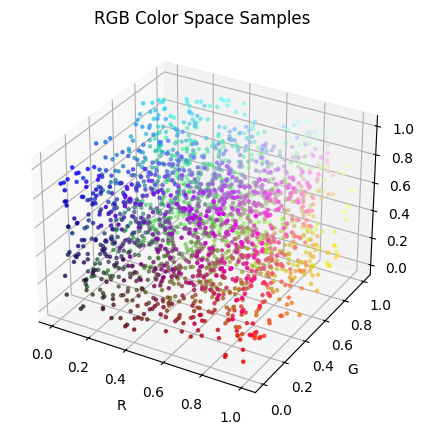

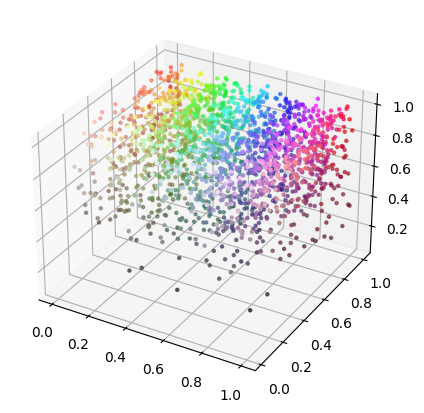

In [11]:
# Generate and visualize data
n_samples = 2000
batch_size = 64

# Create model
model = RGBtoHSV()
print("Model architecture:")
print(model)

# Training setup
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Prepare data
rgb_data = generate_rgb_samples(n_samples)
hsv_data = rgb_to_hsv_batch(rgb_data)

# Create dataset and dataloader
dataset = RGBHSVDataset(rgb_data, hsv_data)

train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Create and train model
model = RGBtoHSV()
train_model(model, train_loader, num_epochs=100)

visualize_model_structure(model)

visualize_samples(rgb_data)
visualize_hsv_samples(hsv_data)

In [12]:
inputs, activations, outputs = collect_activations(model, train_loader)
print("Input shape:", inputs.shape)
print("Activation shape:", activations.shape)
print("Output shape:", outputs.shape)

Input shape: (2000, 3)
Activation shape: (2000, 640)
Output shape: (2000, 3)


In [13]:
new_color = np.random.uniform(0, 1, 3) 
new_input, new_activations, new_output = collect_single_color_activations(model, new_color)
neighbors, distances, indices = find_color_knn(new_activations, activations, k=15)
blended_color = blend_with_inverse_distance_weighting(neighbors, distances)

c:\Users\Lukas\miniconda3\envs\ml_train\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Lukas\miniconda3\envs\ml_train\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\Lukas\miniconda3\envs\ml_train\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Lukas\miniconda3\envs\ml_train\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\Lukas\miniconda3\envs\ml_train\Lib\subprocess

Total samples: 2000
Red group: 664 samples (33.2%)
Green group: 658 samples (32.9%)
Blue group: 678 samples (33.9%)


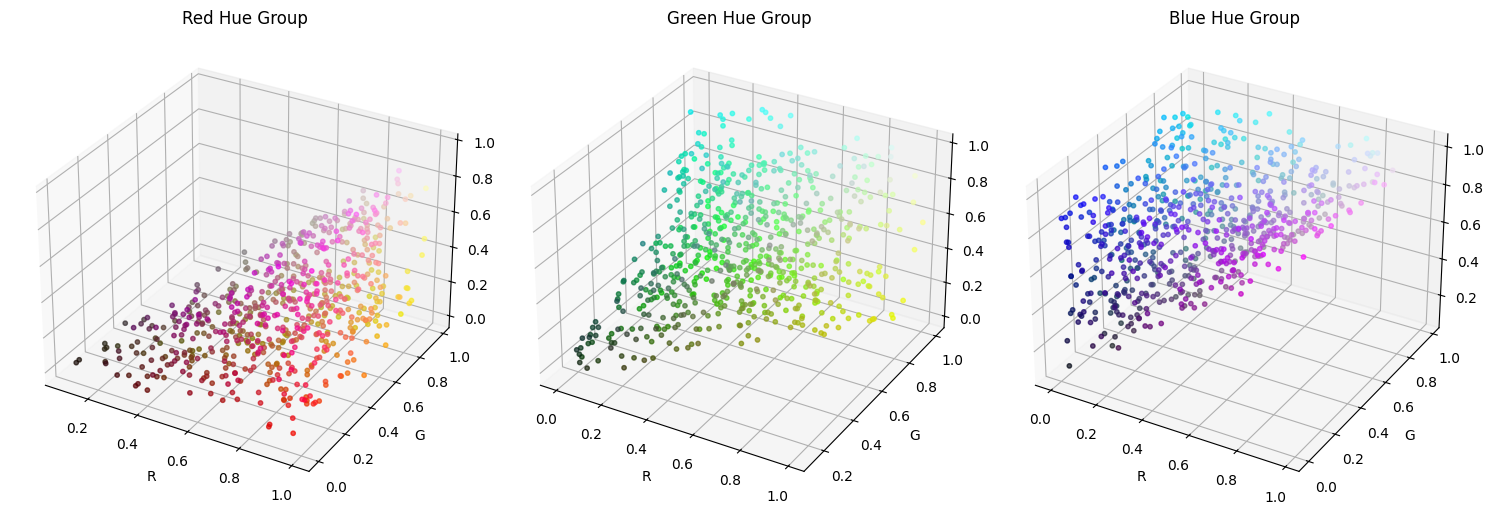

Red group explained variance: 99.88%
Green group explained variance: 99.88%
Blue group explained variance: 99.87%


In [14]:
# Split activations by hue color group
act_red, act_green, act_blue, idx_red, idx_green, idx_blue = split_activations_by_hue_group(activations, rgb_to_hsv_batch(inputs))

# You can also get the inputs for each group using the indices
inputs_red = inputs[idx_red]
inputs_green = inputs[idx_green] 
inputs_blue = inputs[idx_blue]

# Visualize the distribution of each group
plt.figure(figsize=(15, 5))

# Plot RGB color space for each group
for i, (title, data, color) in enumerate([
    ('Red Hue Group', inputs_red, 'red'),
    ('Green Hue Group', inputs_green, 'green'),
    ('Blue Hue Group', inputs_blue, 'blue')
]):
    ax = plt.subplot(1, 3, i+1, projection='3d')
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=data, alpha=0.7, s=10)
    ax.set_title(title)
    ax.set_xlabel('R')
    ax.set_ylabel('G')
    ax.set_zlabel('B')

plt.tight_layout()
plt.show()

# Optional: Apply PCA to each color group separately
from sklearn.decomposition import PCA

n_components = 10
pca_red = PCA(n_components=n_components)
reduced_red = pca_red.fit_transform(act_red)
print(f"Red group explained variance: {sum(pca_red.explained_variance_ratio_)*100:.2f}%")

pca_green = PCA(n_components=n_components)
reduced_green = pca_green.fit_transform(act_green)
print(f"Green group explained variance: {sum(pca_green.explained_variance_ratio_)*100:.2f}%")

pca_blue = PCA(n_components=n_components)
reduced_blue = pca_blue.fit_transform(act_blue)
print(f"Blue group explained variance: {sum(pca_blue.explained_variance_ratio_)*100:.2f}%")

Total samples: 2000
Red group: 648 samples (32.4%)
Green group: 640 samples (32.0%)
Blue group: 712 samples (35.6%)
Layer linear1: 84.85% variance explained with 2 components
Layer relu2: 73.63% variance explained with 2 components
Layer linear3: 94.28% variance explained with 2 components
Layer relu4: 80.42% variance explained with 2 components
Layer linear5: 92.13% variance explained with 2 components
Layer relu6: 64.16% variance explained with 2 components


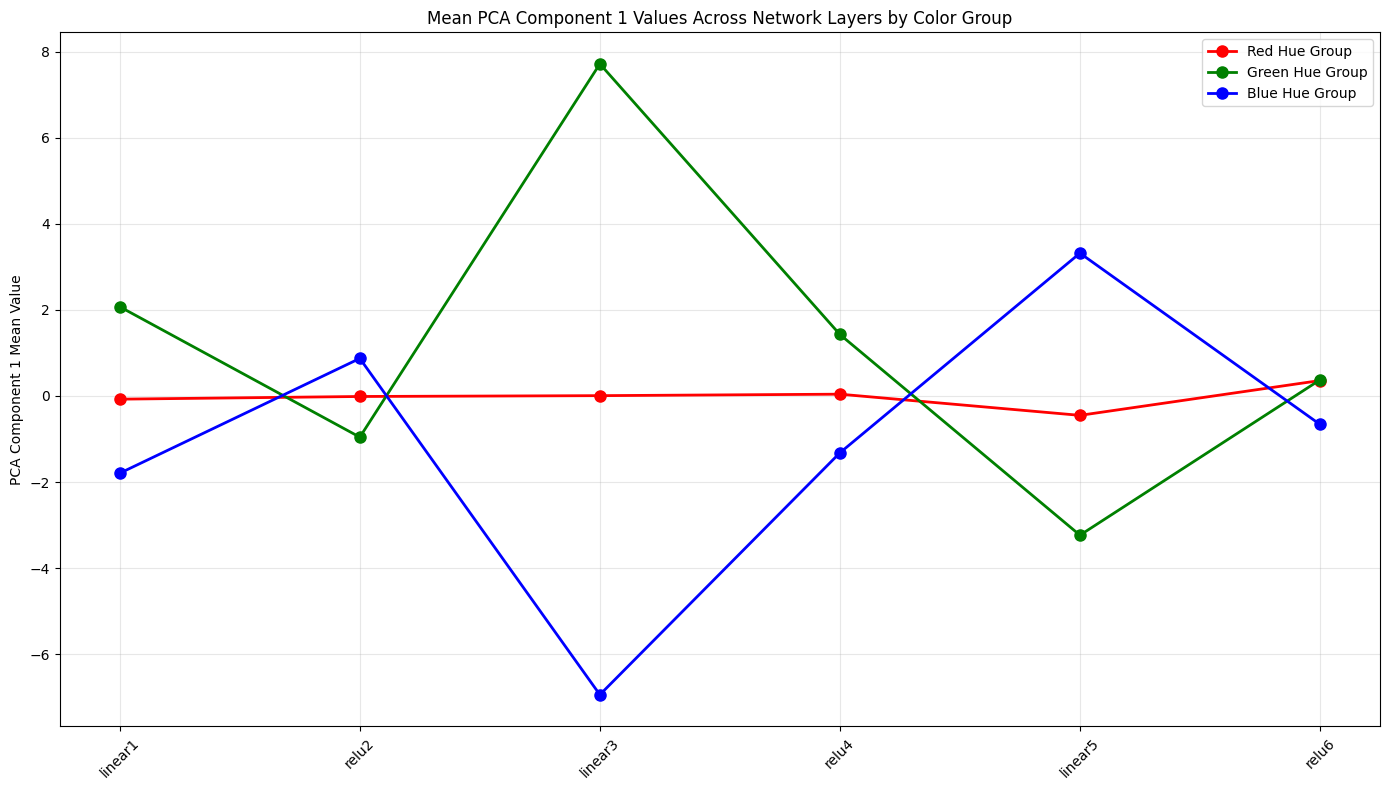

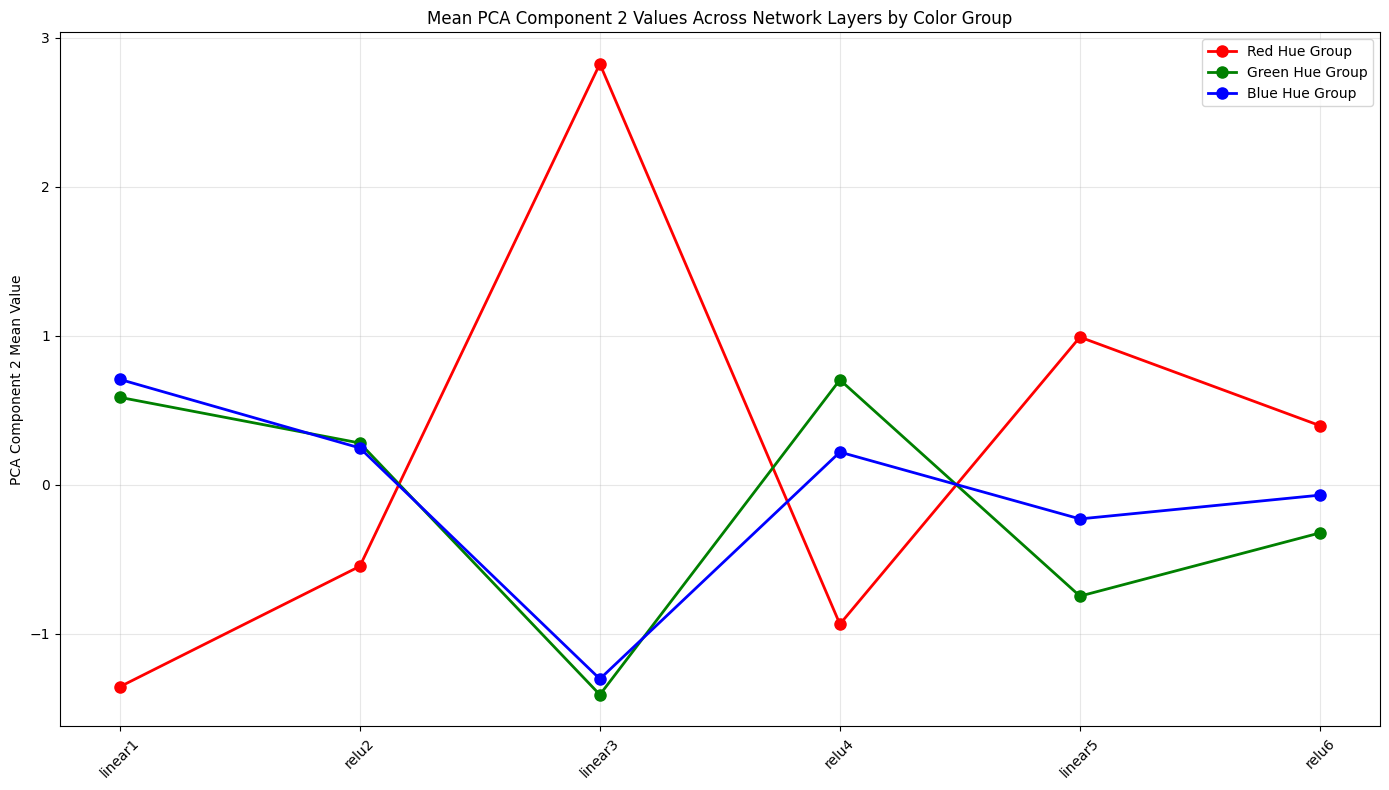

In [15]:
# Apply PCA by layer and analyze color groups
reduced_data, group_means = analyze_color_groups_with_pca(
    model, 
    activations, 
    outputs, 
    inputs, 
    n_components=2,  # Reduce to 3 dimensions 
    layer_pca=True   # Apply PCA separately for each layer
)

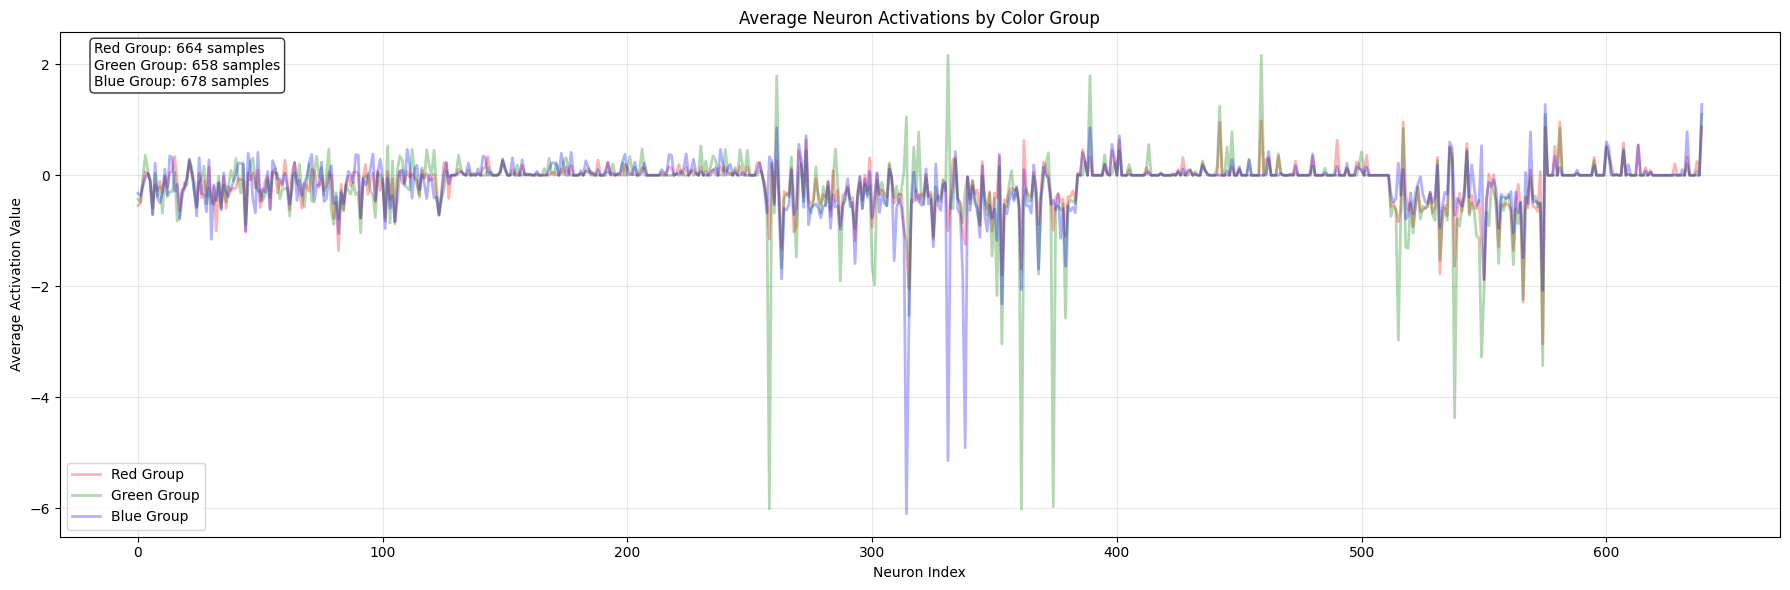

Top 5 neurons differentiating red and green groups: [538 331 361 258 374]


In [16]:
# Using the previously split color activations
fig, ax, avg_data = plot_color_group_activations(
    act_red,  # Red hue group activations
    act_green,  # Green hue group activations
    act_blue,  # Blue hue group activations
    figsize=(18, 6),
    show_std=False,
    title="Average Neuron Activations by Color Group"
)

# You can access the average activation values if needed
red_avg = avg_data['red']
green_avg = avg_data['green']
blue_avg = avg_data['blue']

# If you want to find neurons with the biggest differences between groups:
diff_red_green = np.abs(red_avg - green_avg)
diff_red_blue = np.abs(red_avg - blue_avg)
diff_green_blue = np.abs(green_avg - blue_avg)

# Get top 5 most differentiating neurons between red and green
top_diff_neurons = np.argsort(diff_red_green)[-5:]
print(f"Top 5 neurons differentiating red and green groups: {top_diff_neurons}")

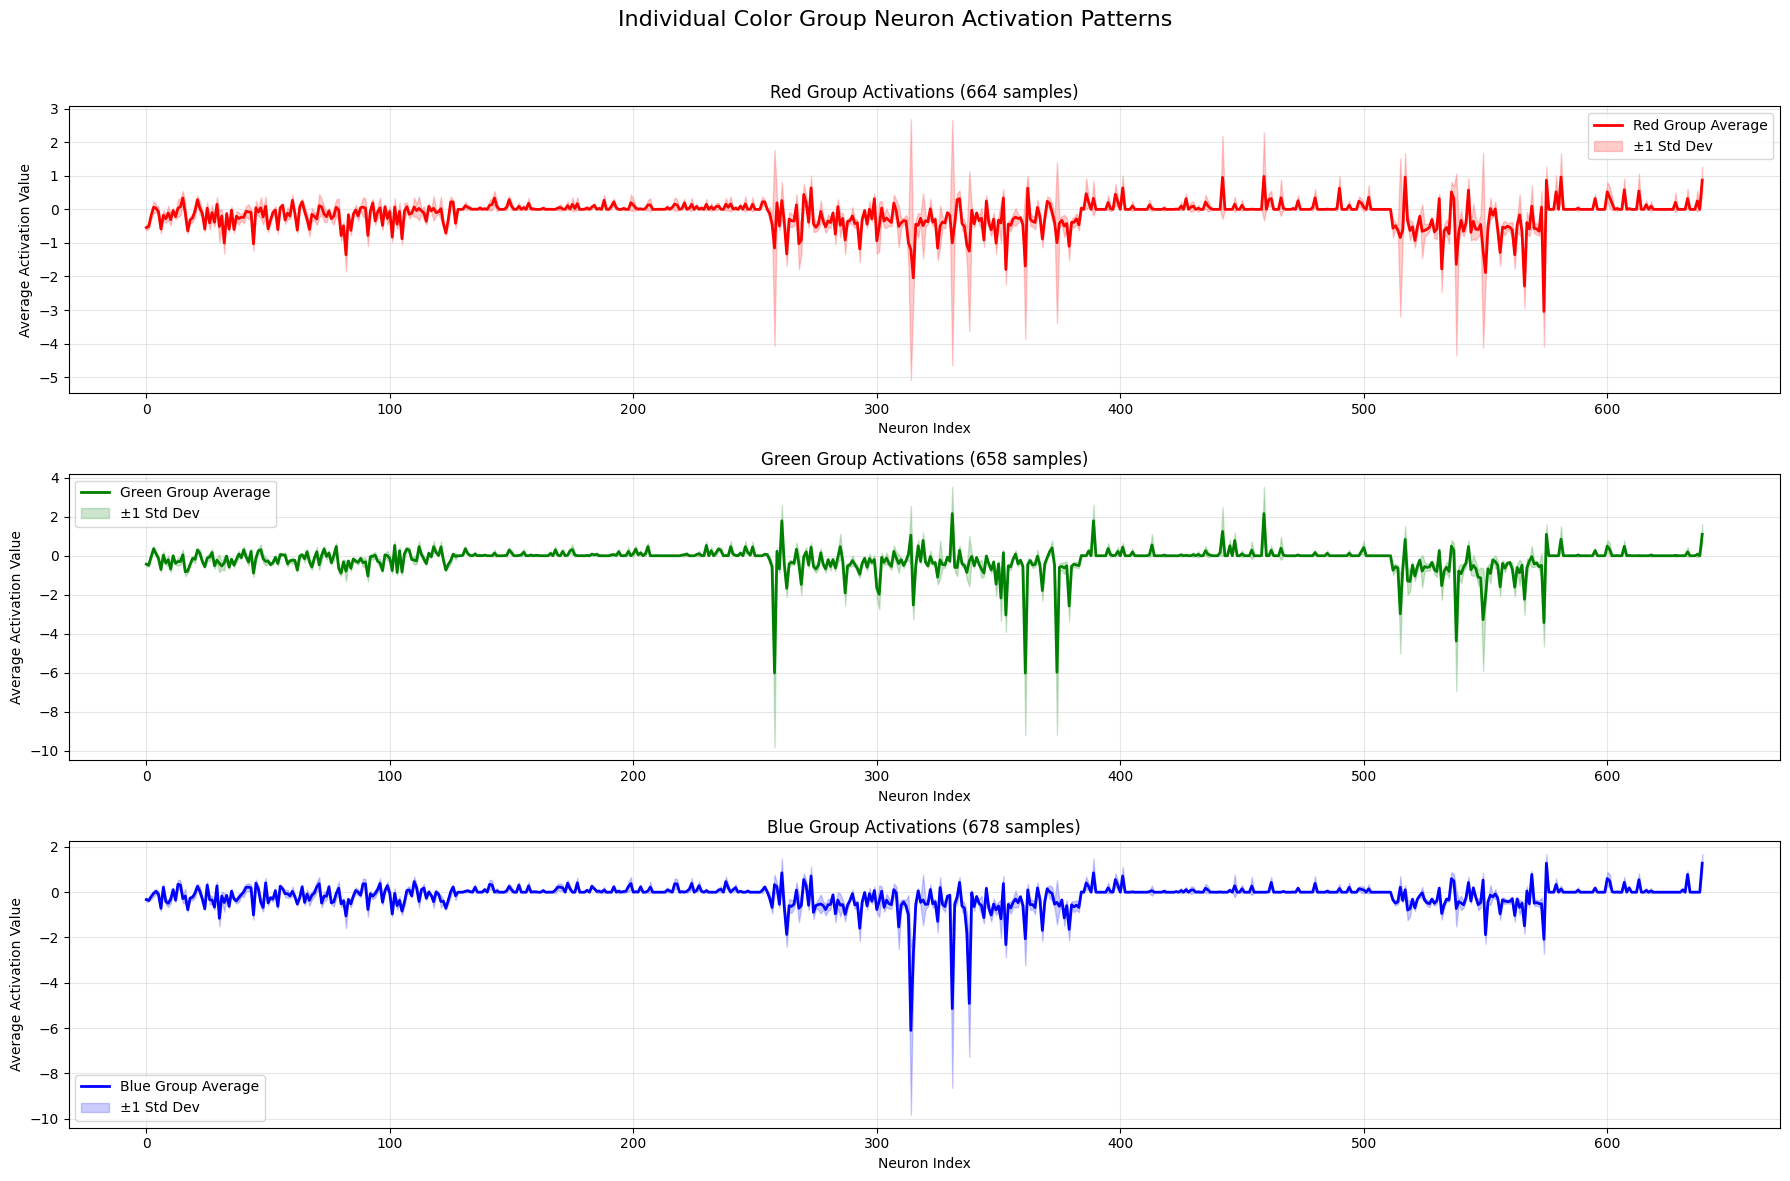

Top 5 neurons differentiating red and green groups: [538 331 361 258 374]


In [17]:
# Using the previously split color activations
fig, axes, avg_data = plot_color_group_activations_individual(
    act_red,  # Red hue group activations
    act_green,  # Green hue group activations
    act_blue,  # Blue hue group activations
    figsize=(18, 12),
    show_std=True,  # Show standard deviation
    alpha=0.8,
    title="Individual Color Group Neuron Activation Patterns"
)

# You can access the average activation values if needed
red_avg = avg_data['red']
green_avg = avg_data['green']
blue_avg = avg_data['blue']

# Find neurons with the biggest differences between groups
diff_red_green = np.abs(red_avg - green_avg)
diff_red_blue = np.abs(red_avg - blue_avg)
diff_green_blue = np.abs(green_avg - blue_avg)

# Get top 5 most differentiating neurons between red and green
top_diff_neurons = np.argsort(diff_red_green)[-5:]
print(f"Top 5 neurons differentiating red and green groups: {top_diff_neurons}")

In [28]:
# Get indices of the 20 neurons with highest variance
high_var_indices, variances = find_highest_variance_neurons(activations, num_neurons=10)

# Print the neuron indices with their corresponding variances
for i, (idx, var) in enumerate(zip(high_var_indices, variances)):
    print(f"Rank {i+1}: Neuron {idx} - Variance: {var:.6f}")

# You can use these indices to create a mask for neuron selection
high_var_mask = np.zeros(activations.shape[1], dtype=bool)
high_var_mask[high_var_indices] = True

# Use the mask to select only high variance activations
masked_activations = activations[:, high_var_mask]

Found 10 neurons with highest variance
Highest variance: 19.403393
Lowest variance in selection: 1.973032
Rank 1: Neuron 314 - Variance: 19.403393
Rank 2: Neuron 331 - Variance: 18.184223
Rank 3: Neuron 258 - Variance: 14.988331
Rank 4: Neuron 374 - Variance: 11.765467
Rank 5: Neuron 361 - Variance: 9.141389
Rank 6: Neuron 338 - Variance: 8.335915
Rank 7: Neuron 549 - Variance: 7.538939
Rank 8: Neuron 538 - Variance: 7.208149
Rank 9: Neuron 515 - Variance: 5.049277
Rank 10: Neuron 459 - Variance: 1.973032


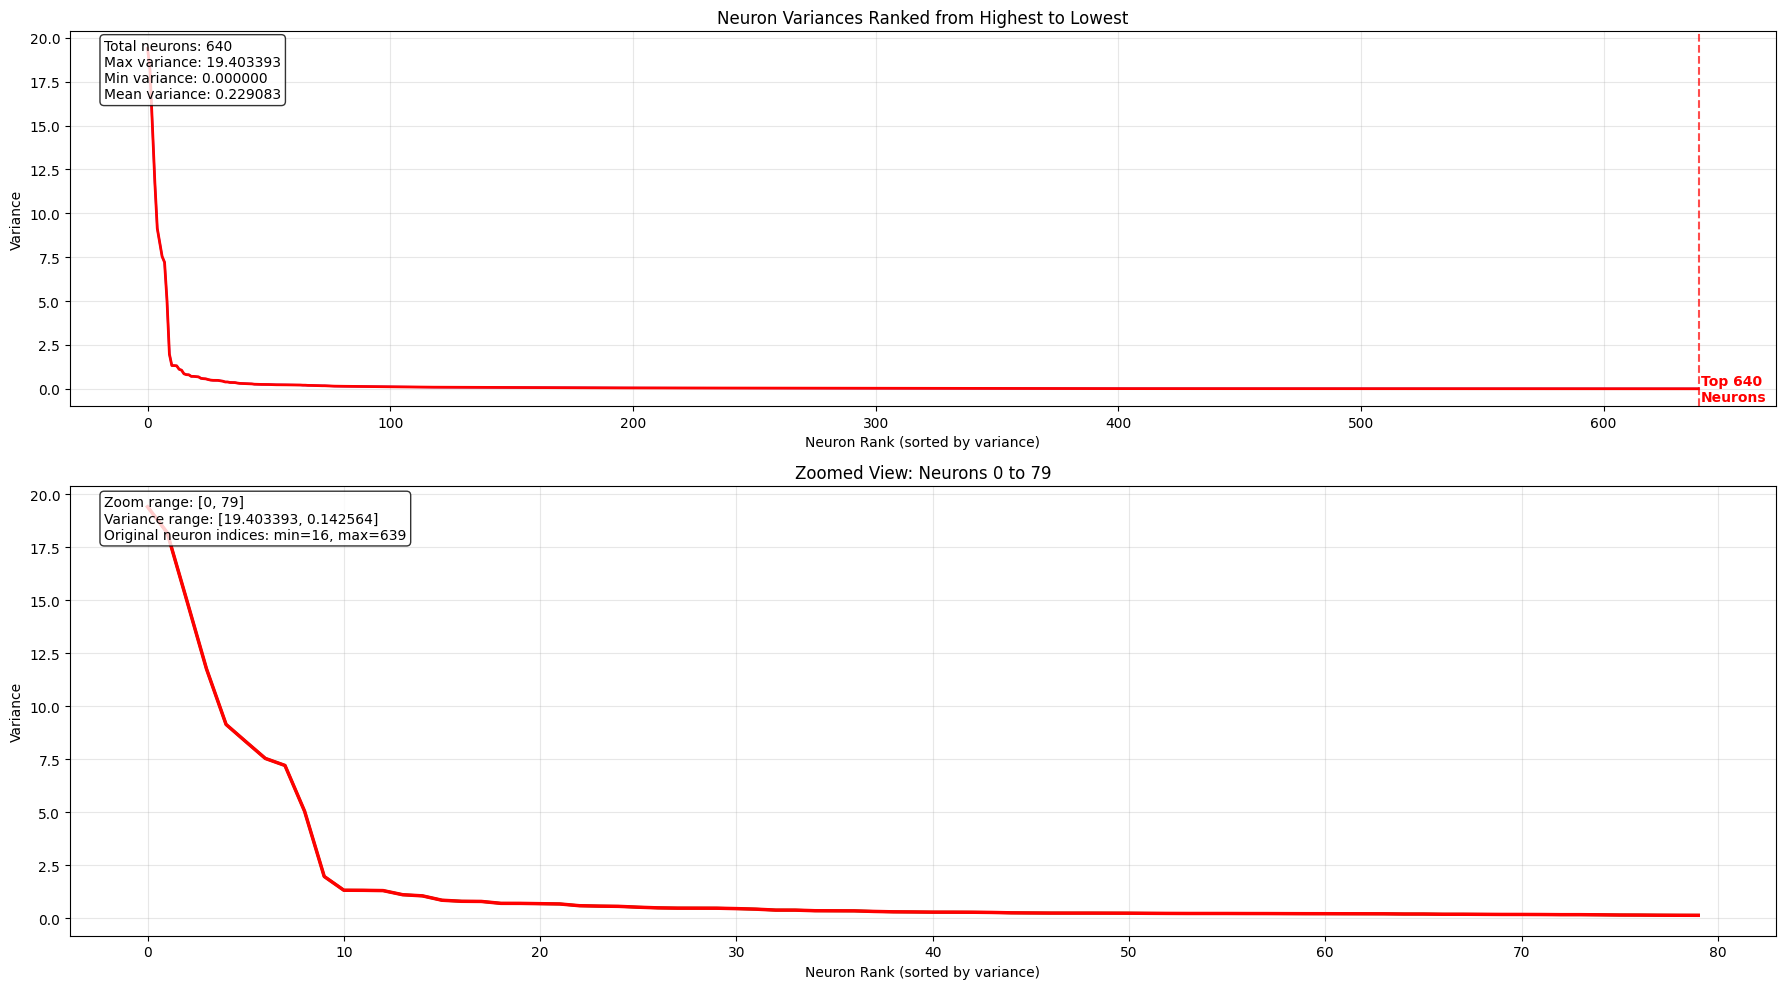

In [34]:
# Calculate variances for all neurons and plot them in descending order
fig, axes, sorted_indices = plot_neuron_variances_ranked_with_zoom(
    activations, 
    figsize=(18, 10),
    highlight_top_n=640,  # Highlight the top 640 neurons
    zoom_range=(0, 80)   # Zoom in on the first 100 neurons
)

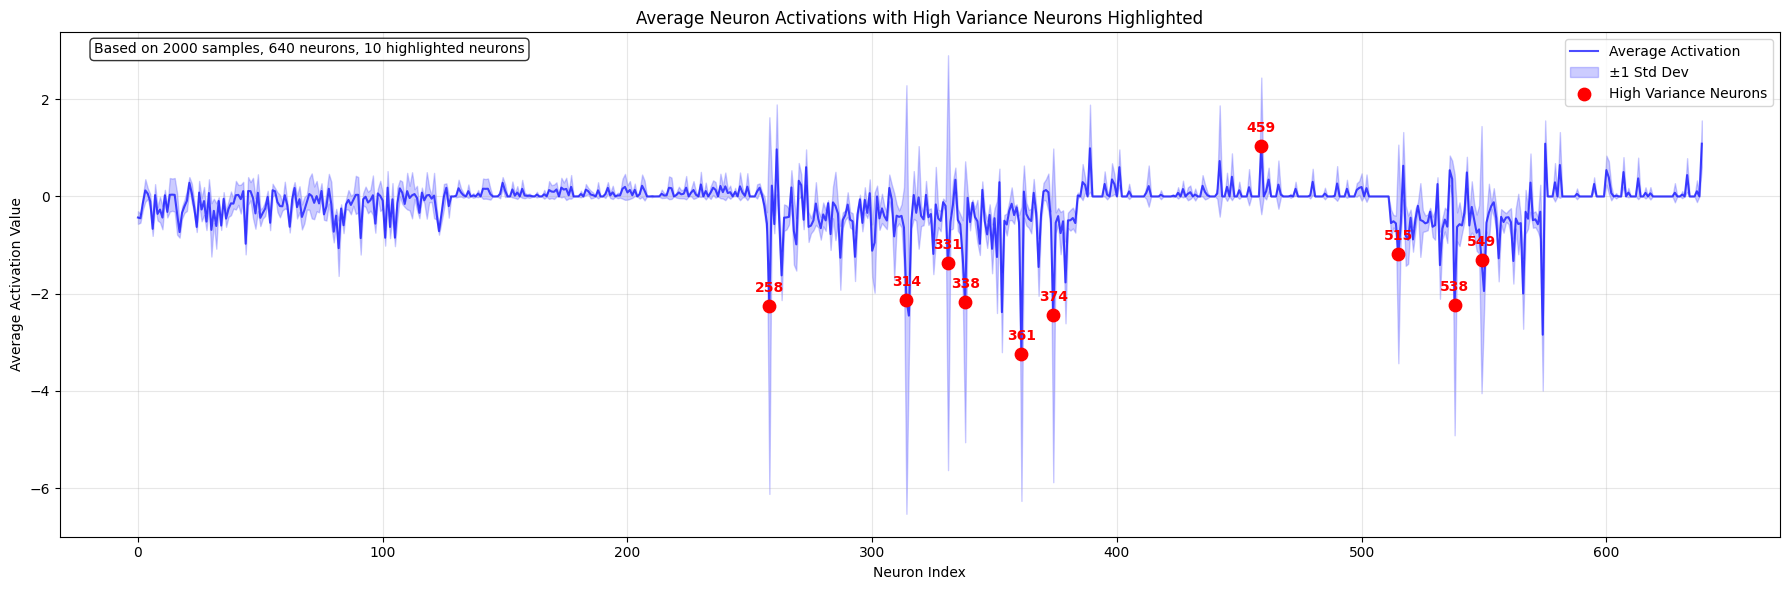

In [22]:
# Plot average activations with high variance neurons highlighted
fig, ax = plot_average_activations_with_highlights(
    activations, 
    highlight_indices=high_var_indices,
    title="Average Neuron Activations with High Variance Neurons Highlighted"
)